# $ \ell^+ \ell^- \to W^+ W^-, ZZ, ZH, \gamma \gamma, Z \gamma $ cross sections

TO-DO: Check the energy dependence \
Keep eyes open to other processes that are sensitive to the operators in game

We will try to automatize this procedure inside this Jupyter notebook.

In [22]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
def process_to_dirname(process):
    return process.replace(" ", "").replace("+", "p").replace("-", "m").replace(">", "_")

In [24]:
def extract_cross_section(mg_path, output_dir):
    banner_path = os.path.join(mg_path, output_dir, "Events", "run_01", "run_01_tag_1_banner.txt")
    if os.path.exists(banner_path):
        with open(banner_path, "r") as f:
            for line in f:
                if line.startswith("#  Integrated weight (pb)  :"):
                    return float(re.findall(r"[-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?", line)[0])
    return None

In [25]:
def run_madgraph(process, generate_cmd, params, mg_path, pt_cuts):
    """
    Runs MadGraph for a given process and parameter set. 
    process is a string that specifies the process in the MadGraph form.
    generate_cmd is the generate command given as a string, which includes the process, but also the order of it (is it SM, NP int. or NP^2). 
    It is created in the main loop, see below.
    params is a dictionary of the form {paramWC: value}, which is created in the main loop.
    mg_path is a string that specifies the path to the MadGraph directory, more precisely it points to ~/MG5_aMC_v3_4_0/bin.
    pt_cuts is also a dictionary of the form {PDG_ID: pT}, and used to create the MadGraph commands to set the minimum pTs of the outgoing particles.
    """

    # Create the string that will set the WCs to their values
    param_str = " \n".join([f"set {k} {v}" for k, v in params.items()])
    
    # Create the string that will set the pT cuts
    pt_cut_str_1 = [f"{pdg}: {pt} " for pdg, pt in pt_cuts.items()]
    pt_cut_str = "set pt_min_pdg" + " {" + ", ".join(pt_cut_str_1) + "}"
    
    output_dir = os.path.join(mg_path, process_to_dirname(process)) # For every process, change the folder name

    ebeam = 7_000 # in GeV
    lambdaNP = 1_000 # in GeV
    
    script_content = f"""
    import model higgsVV_feynman_massive_muon 
    define mu = mu+ mu-
    generate {generate_cmd}
    output {process_to_dirname(process)}
    launch
    shower = OFF
    detector = OFF
    analysis = OFF
    madspin = OFF
    reweight = OFF
    0
    set LambdaSMEFT {lambdaNP}
    set lpp1 0
    set lpp2 0
    set polbeam1 0
    set polbeam2 0
    set ebeam1 {ebeam}
    set ebeam2 {ebeam}
    set pdlabel none
    set use_syst False
    set nevents 100
    {param_str}
    {pt_cut_str}
    0
    """
    # LambdaSMEFT is set to 50 TeV!
    #lpp1 and lpp2 set to zero mean NO PDF
    #polbeam1 and polbeam2 are their polarizations, from -100 (left-handed) to 100 (right-handed)
    #pdlabel is set to none since we don't want to use any PDF
    
    script_path = os.path.join(mg_path, "run_mg5_script.txt")
    with open(script_path, "w") as f:
        f.write(script_content)
    
    os.system(f"cd {mg_path} && ./mg5_aMC {script_path}") # Command to run MadGraph
    
    # Extract cross-section (this will depend on MG5 output format)
    cross_section = extract_cross_section(mg_path, output_dir)
    return cross_section

In [26]:
# Define processes and parameters
processes = [
    "mu+ mu- > z h",
    "mu+ mu- > a a",
    "mu+ mu- > w+ w-",
    "mu+ mu- > z a",
    "mu+ mu- > z z"
]

params_list = ["cBB", "cHW", "cW", "cHB", "cB"]
mg_path = "/home/armanubuntu/MG5_aMC_v3_4_0/bin/"

os.chdir(mg_path) #Go to this folder

data = []

# Example of default pT cuts (all set to zero for now, can be modified)
default_pt_cuts = {23: 0, 25: 0, 22: 0, 24: 0}  # PDG IDs for Z, H, A, W+

# Running MG5 (can be skipped if we have the results already)

In [27]:
# Compute cross-sections
for process in processes:
    # SM only
    xs_sm = run_madgraph(process, f" {process}", {p: 0 for p in params_list}, mg_path, default_pt_cuts)
    data.append([process, 'SM', "SM only", xs_sm])
    
    os.system("rm -r " + os.path.join(mg_path, process_to_dirname(process))) # Delete the folder after every run so we are sure we are not reading from the previous run
    
    # Interference terms. See https://answers.launchpad.net/mg5amcnlo/+question/254944 and https://answers.launchpad.net/mg5amcnlo/+question/255413 for information, but this doesn't seem correct, since NP^2 > 2 doesn't give me anything, and clearly it should.
    for param in params_list:
        generate_cmd = f" {process}  NP^2 == 1  {param}^2 == 1"
        xs_int = run_madgraph(process, generate_cmd, {p: 0.999999 if p == param else 0 for p in params_list}, mg_path, default_pt_cuts)
        data.append([process, param, "Interference", xs_int])
        os.system("rm -r " + os.path.join(mg_path, process_to_dirname(process))) # Delete the folder after every run so we are sure we are not reading from the previous run
    
    # Pure NP^2 terms
    for param in params_list:
        generate_cmd = f" {process}  NP^2 == 2  {param}^2 == 2"
        xs_np2 = run_madgraph(process, generate_cmd, {p: 0.999999 if p == param else 0 for p in params_list}, mg_path, default_pt_cuts)
        data.append([process, param, "NP^2", xs_np2])
        os.system("rm -r " + os.path.join(mg_path, process_to_dirname(process))) # Delete the folder after every run so we are sure we are not reading from the previous run
    
    # Mixed NP^2 terms
    for i in range(len(params_list)):
        for j in range(i+1, len(params_list)):
            p1, p2 = params_list[i], params_list[j]
            generate_cmd = f" {process}  NP^2 == 2  {p1}^2 == 1  {p2}^2 == 1"
            xs_mixed = run_madgraph(process, generate_cmd, {p: 0.999999 if p in [p1, p2] else 0 for p in params_list}, mg_path, default_pt_cuts)
            data.append([process, f"{p1} + {p2}", "Mixed NP^2", xs_mixed])
            os.system("rm -r " + os.path.join(mg_path, process_to_dirname(process))) # Delete the folder after every run so we are sure we are not reading from the previous run


************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.5.3                 2023-12-23         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zh/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zh  


100%|██████████| 721/721 [00:00<00:00, 101143.62it/s]


INFO:     P1_mupmum_zh  
INFO:  Idle: 1,  Running: 1,  Completed: 0 [ current time: 15h59 ] 
INFO:  Idle: 0,  Running: 1,  Completed: 1 [  0.12s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 2 [  0.24s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 1944257.489684904 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 6.172022e-05 +- 3.388576651675597e-07
    P1_mupmum_zh 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 15h59 ] 
INFO: Combining runs 
sum of cpu time of last step: 1 seconds
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.11396622657775879 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   6.172e-05 +- 3.389e-07 pb
     Nb of events :  100
 
store_events
INFO

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zh/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zh  


100%|██████████| 735/735 [00:00<00:00, 80871.29it/s]


INFO:     P1_mupmum_zh  
INFO:  Idle: 1,  Running: 1,  Completed: 0 [ current time: 15h59 ] 
INFO:  Idle: 0,  Running: 1,  Completed: 1 [  0.26s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 2 [  0.27s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 15346983.793329334 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 2.0443799999999997e-06 +- 4.295014304082933e-08
    P1_mupmum_zh 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 15h59 ] 
INFO: Combining runs 
sum of cpu time of last step: 1 seconds
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.14293956756591797 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   2.044e-06 +- 4.295e-08 pb
     Nb of events :  100
 
store_

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zh/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zh  


100%|██████████| 735/735 [00:00<00:00, 62260.19it/s]


INFO:     P1_mupmum_zh  
INFO:  Idle: 1,  Running: 1,  Completed: 0 [ current time: 15h59 ] 
INFO:  Idle: 0,  Running: 1,  Completed: 1 [  0.36s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 2 [  0.38s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 6140.393967676966 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 0.0195423 +- 0.00010334779779250258
    P1_mupmum_zh 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 15h59 ] 
INFO: Combining runs 
sum of cpu time of last step: 1 seconds
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.20606684684753418 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   0.01954 +- 0.0001033 pb
     Nb of events :  100
 
store_events
INFO: St

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zh/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zh  


100%|██████████| 735/735 [00:00<00:00, 18662.23it/s]


INFO:     P1_mupmum_zh  
INFO:  Idle: 1,  Running: 1,  Completed: 0 [ current time: 15h59 ] 
INFO:  Idle: 0,  Running: 1,  Completed: 1 [  0.44s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 2 [  0.45s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 6138.34290318043 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 0.019549249999999997 +- 0.00010356061062609663
    P1_mupmum_zh 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 15h59 ] 
INFO: Combining runs 
sum of cpu time of last step: 1 seconds
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.2893216609954834 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   0.01955 +- 0.0001036 pb
     Nb of events :  100
 
store_events

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zh/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zh  


100%|██████████| 735/735 [00:00<00:00, 46306.57it/s]


INFO:     P1_mupmum_zh  
INFO:  Idle: 1,  Running: 1,  Completed: 0 [ current time: 16h00 ] 
INFO:  Idle: 0,  Running: 1,  Completed: 1 [  0.51s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 2 [  0.52s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 2 seconds
INFO: Effective Luminosity 7307.755782109518 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 0.00424611 +- 8.686303469698718e-05
    P1_mupmum_zh 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h00 ] 
INFO: Combining runs 
sum of cpu time of last step: 2 seconds
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.2902514934539795 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   0.004246 +- 8.686e-05 pb
     Nb of events :  100
 
store_events
INFO: St

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zh/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zh  


100%|██████████| 735/735 [00:00<00:00, 43145.24it/s]


INFO:     P1_mupmum_zh  
INFO:  Idle: 1,  Running: 1,  Completed: 0 [ current time: 16h00 ] 
INFO:  Idle: 0,  Running: 1,  Completed: 1 [  0.48s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 2 [  0.48s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 2 seconds
INFO: Effective Luminosity 7306.0784137042565 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 0.004251652999999999 +- 8.700797290162552e-05
    P1_mupmum_zh 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h00 ] 
INFO: Combining runs 
sum of cpu time of last step: 2 seconds
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.37061214447021484 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   0.004252 +- 8.701e-05 pb
     Nb of events :  100
 
store_eve

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zh/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zh  


100%|██████████| 718/718 [00:00<00:00, 61110.19it/s]


INFO:     P1_mupmum_zh  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h00 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.39s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.39s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 311469.87826718925 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 0.00038527 +- 4.012364276832302e-07
    P1_mupmum_zh 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h00 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.1864786148071289 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   0.0003853 +- 4.012e-07 pb
     Nb of events :  100
 
store_events
INFO: St

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zh/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zh  


100%|██████████| 718/718 [00:00<00:00, 44882.27it/s]


INFO:     P1_mupmum_zh  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h01 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.49s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.49s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 42.8893098395225 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 2.7979000000000003 +- 0.005505195635034235
    P1_mupmum_zh 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h01 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.15430164337158203 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   2.798 +- 0.005505 pb
     Nb of events :  100
 
store_events
INFO: S

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zh/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zh  


100%|██████████| 718/718 [00:00<00:00, 21071.89it/s]


INFO:     P1_mupmum_zh  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h01 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.47s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.47s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 42.866328498964066 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 2.7994 +- 0.005505971689901793
    P1_mupmum_zh 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h01 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.1609172821044922 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   2.799 +- 0.005506 pb
     Nb of events :  100
 
store_events
INFO: Storing part

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zh/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zh  


100%|██████████| 718/718 [00:00<00:00, 16178.91it/s]


INFO:     P1_mupmum_zh  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h01 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.65s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.65s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 92.22539887485014 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 1.3011599999999999 +- 0.002560075030150484
    P1_mupmum_zh 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h01 ] 
INFO: Combining runs 
sum of cpu time of last step: 1 seconds
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.22580218315124512 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   1.301 +- 0.00256 pb
     Nb of events :  100
 
store_events
INFO:

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zh/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zh  


100%|██████████| 718/718 [00:00<00:00, 38799.12it/s]


INFO:     P1_mupmum_zh  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h02 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.81s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.81s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 92.18430715811144 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 1.3017400000000001 +- 0.002560285540716113
    P1_mupmum_zh 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h02 ] 
INFO: Combining runs 
sum of cpu time of last step: 1 seconds
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.3999364376068115 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   1.302 +- 0.00256 pb
     Nb of events :  100
 
store_events
INFO: 

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zh/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zh  


100%|██████████| 728/728 [00:00<00:00, 38374.43it/s]


INFO:     P1_mupmum_zh  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h02 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.44s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.44s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 184675.04886194004 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -0.0006497899999999999 +- 2.051686940056889e-07
    P1_mupmum_zh 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h02 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 184675.04886194004 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -0.0006497899999999999 +- 

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zh/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zh  


100%|██████████| 728/728 [00:00<00:00, 37428.49it/s]


INFO:     P1_mupmum_zh  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h02 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.46s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.46s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 147896.17688382755 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -0.0008097600000000001 +- 7.45911853505493e-13
    P1_mupmum_zh 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h02 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 147896.17688382755 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -0.0008097600000000001 +- 7

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zh/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zh  


100%|██████████| 728/728 [00:00<00:00, 45298.08it/s]


INFO:     P1_mupmum_zh  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h03 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.63s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.63s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 151522.8041820294 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 0.00079196 +- 4.5483257985768787e-07
    P1_mupmum_zh 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h03 ] 
INFO: Combining runs 
sum of cpu time of last step: 1 seconds
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.2838408946990967 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   0.000792 +- 4.548e-07 pb
     Nb of events :  100
 
store_events
INFO: S

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zh/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zh  


100%|██████████| 728/728 [00:00<00:00, 55977.37it/s]


INFO:     P1_mupmum_zh  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h03 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.56s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.56s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 96997.91454483729 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 0.00123714 +- 6.711644987631572e-13
    P1_mupmum_zh 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h03 ] 
INFO: Combining runs 
sum of cpu time of last step: 1 seconds
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.20186805725097656 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   0.001237 +- 6.712e-13 pb
     Nb of events :  100
 
store_events
INFO: S

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zh/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zh  


100%|██████████| 728/728 [00:00<00:00, 68760.63it/s]


INFO:     P1_mupmum_zh  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h03 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.38s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.38s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 21.441206425214858 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 5.5967 +- 0.011011591483977236
    P1_mupmum_zh 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h03 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.14149069786071777 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   5.597 +- 0.01101 pb
     Nb of events :  100
 
store_events
INFO: Storing part

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zh/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zh  


100%|██████████| 728/728 [00:00<00:00, 36189.51it/s]


INFO:     P1_mupmum_zh  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h04 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.48s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.49s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 70.31195068788526 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -1.70668 +- 0.0033577459641849026
    P1_mupmum_zh 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h04 ] 
INFO: Combining runs 
sum of cpu time of last step: 1 seconds
INFO: finish refine 
refine 100 --treshold=0.9
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 70.31195068788526 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -1.70668 +- 0.0033577459641849026
    P

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zh/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zh  


100%|██████████| 728/728 [00:00<00:00, 22372.90it/s]


INFO:     P1_mupmum_zh  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h04 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.39s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.39s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 70.30082896394154 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -1.70695 +- 0.0033577459641849026
    P1_mupmum_zh 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h04 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 70.30082896394154 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -1.70695 +- 0.0033577459641849026
    P1_m

stty: 'standard input': Inappropriate ioctl for device


Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zh/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zh  


100%|██████████| 728/728 [00:00<00:00, 53022.39it/s]


INFO:     P1_mupmum_zh  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h04 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.54s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.54s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 70.28765221669684 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -1.70689 +- 0.003358242387023307
    P1_mupmum_zh 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h04 ] 
INFO: Combining runs 
sum of cpu time of last step: 1 seconds
INFO: finish refine 
refine 100 --treshold=0.9
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 70.28765221669684 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -1.70689 +- 0.003358242387023307
    P1_

stty: 'standard input': Inappropriate ioctl for device


The following switches determine which programs are run:
/===========================================================================\
| 1. Choose the shower/hadronization program     shower = OFF               |
| 2. Choose the detector simulation program    detector = OFF               |
| 3. Choose an analysis package (plot/convert) analysis = ExRoot            |
| 4. Decay onshell particles                    madspin = OFF               |
| 5. Add weights to events for new hypp.       reweight = OFF               |
\===========================================================================/
Either type the switch number (1 to 5) to change its setting,
Set any switch explicitly (e.g. type 'shower=Pythia8' at the prompt)
Type 'help' for the list of all valid option
Type '0', 'auto', 'done' or just press enter when you are done.
The following switches determine which programs are run:
/===========================================================================\
| 1. Choose the shower

100%|██████████| 728/728 [00:00<00:00, 54146.92it/s]


INFO:     P1_mupmum_zh  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h04 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.43s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.43s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 70.27900766041184 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -1.7071 +- 0.003358311510268218
    P1_mupmum_zh 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h04 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 70.27900766041184 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -1.7071 +- 0.003358311510268218
    P1_mupmu

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zh/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zh  


100%|██████████| 728/728 [00:00<00:00, 31935.55it/s]


INFO:     P1_mupmum_zh  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h05 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.43s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.43s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 46.10596688054712 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 2.6027 +- 0.005120432833267125
    P1_mupmum_zh 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h05 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.1498243808746338 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   2.603 +- 0.00512 pb
     Nb of events :  100
 
store_events
INFO: Storing parton

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_aa/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_aa  


100%|██████████| 713/713 [00:00<00:00, 55607.93it/s]


INFO:     P1_mupmum_aa  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h05 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.43s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.43s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 8645.533141210375 pb^-1 
INFO: need to improve 1 channels 
- Current estimate of cross-section: 0.01388 +- 0.00091612
    P1_mupmum_aa 
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h05 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  19.6s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  19.6s  ] 
INFO: Combining runs 
sum of cpu time of last step: 19 seconds
INFO: finish refine 
refine 100 --treshold=0.9
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 19 seconds
INFO: Effective Luminosity 7074.220361964276 pb^-1 
INFO: nee

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_aa/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_aa  


100%|██████████| 726/726 [00:00<00:00, 71592.99it/s]


INFO:     P1_mupmum_aa  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h06 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.85s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.85s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 312667138498.7491 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -3.8379473e-10 +- 7.191800210199491e-12
    P1_mupmum_aa 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h06 ] 
INFO: Combining runs 
sum of cpu time of last step: 1 seconds
INFO: finish refine 
refine 100 --treshold=0.9
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 312667138498.7491 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -3.8379473e-10 +- 7.1918002101994

Command "import /home/armanubuntu/MG5_aMC_v3_4_0/bin/run_mg5_script.txt" interrupted in sub-command:
"generate  mu+ mu- > a a  NP^2 == 1  cHW^2 == 1" with error:
NoDiagramException : No amplitudes generated from process Process: mu+ mu- > a a NP=1 cHW=1 cHW^2==1 NP^2==1 @1. Please enter a valid process
rm: cannot remove '/home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_aa': No such file or directory


************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.5.3                 2023-12-23         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

Command "import /home/armanubuntu/MG5_aMC_v3_4_0/bin/run_mg5_script.txt" interrupted in sub-command:
"generate  mu+ mu- > a a  NP^2 == 1  cW^2 == 1" with error:
NoDiagramException : No amplitudes generated from process Process: mu+ mu- > a a NP=1 cW=1 cW^2==1 NP^2==1 @1. Please enter a valid process
rm: cannot remove '/home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_aa': No such file or directory


command not executed:     output mupmum_aa
command not executed:     launch
command not executed:     shower = OFF
command not executed:     detector = OFF
command not executed:     analysis = OFF
command not executed:     madspin = OFF
command not executed:     reweight = OFF
command not executed:     0
command not executed:     set LambdaSMEFT 1000
command not executed:     set lpp1 0
command not executed:     set lpp2 0
command not executed:     set polbeam1 0
command not executed:     set polbeam2 0
command not executed:     set ebeam1 7000
command not executed:     set ebeam2 7000
command not executed:     set pdlabel none
command not executed:     set use_syst False
command not executed:     set nevents 100
command not executed:     set cBB 0 
command not executed: set cHW 0 
command not executed: set cW 0.999999 
command not executed: set cHB 0 
command not executed: set cB 0
command not executed:     set pt_min_pdg {23: 0 , 25: 0 , 22: 0 , 24: 0 }
command not executed:     0
co

Command "import /home/armanubuntu/MG5_aMC_v3_4_0/bin/run_mg5_script.txt" interrupted in sub-command:
"generate  mu+ mu- > a a  NP^2 == 1  cHB^2 == 1" with error:
NoDiagramException : No amplitudes generated from process Process: mu+ mu- > a a NP=1 cHB=1 cHB^2==1 NP^2==1 @1. Please enter a valid process
rm: cannot remove '/home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_aa': No such file or directory


command not executed:     output mupmum_aa
command not executed:     launch
command not executed:     shower = OFF
command not executed:     detector = OFF
command not executed:     analysis = OFF
command not executed:     madspin = OFF
command not executed:     reweight = OFF
command not executed:     0
command not executed:     set LambdaSMEFT 1000
command not executed:     set lpp1 0
command not executed:     set lpp2 0
command not executed:     set polbeam1 0
command not executed:     set polbeam2 0
command not executed:     set ebeam1 7000
command not executed:     set ebeam2 7000
command not executed:     set pdlabel none
command not executed:     set use_syst False
command not executed:     set nevents 100
command not executed:     set cBB 0 
command not executed: set cHW 0 
command not executed: set cW 0 
command not executed: set cHB 0.999999 
command not executed: set cB 0
command not executed:     set pt_min_pdg {23: 0 , 25: 0 , 22: 0 , 24: 0 }
command not executed:     0
co

Command "import /home/armanubuntu/MG5_aMC_v3_4_0/bin/run_mg5_script.txt" interrupted in sub-command:
"generate  mu+ mu- > a a  NP^2 == 1  cB^2 == 1" with error:
NoDiagramException : No amplitudes generated from process Process: mu+ mu- > a a NP=1 cB=1 cB^2==1 NP^2==1 @1. Please enter a valid process
rm: cannot remove '/home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_aa': No such file or directory


command not executed:     output mupmum_aa
command not executed:     launch
command not executed:     shower = OFF
command not executed:     detector = OFF
command not executed:     analysis = OFF
command not executed:     madspin = OFF
command not executed:     reweight = OFF
command not executed:     0
command not executed:     set LambdaSMEFT 1000
command not executed:     set lpp1 0
command not executed:     set lpp2 0
command not executed:     set polbeam1 0
command not executed:     set polbeam2 0
command not executed:     set ebeam1 7000
command not executed:     set ebeam2 7000
command not executed:     set pdlabel none
command not executed:     set use_syst False
command not executed:     set nevents 100
command not executed:     set cBB 0 
command not executed: set cHW 0 
command not executed: set cW 0 
command not executed: set cHB 0 
command not executed: set cB 0.999999
command not executed:     set pt_min_pdg {23: 0 , 25: 0 , 22: 0 , 24: 0 }
command not executed:     0
co

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_aa/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_aa  


100%|██████████| 712/712 [00:00<00:00, 61788.14it/s]


INFO:     P1_mupmum_aa  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h06 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.25s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.25s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 71860590454.51823 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 1.6699e-09 +- 4.6174e-18
    P1_mupmum_aa 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h06 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.07704472541809082 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   1.67e-09 +- 4.617e-18 pb
     Nb of events :  100
 
store_events
INFO: Storing parton

Command "import /home/armanubuntu/MG5_aMC_v3_4_0/bin/run_mg5_script.txt" interrupted in sub-command:
"generate  mu+ mu- > a a  NP^2 == 2  cHW^2 == 2" with error:
NoDiagramException : No amplitudes generated from process Process: mu+ mu- > a a NP=2 cHW=2 cHW^2==2 NP^2==2 @1. Please enter a valid process
rm: cannot remove '/home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_aa': No such file or directory


************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.5.3                 2023-12-23         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

Command "import /home/armanubuntu/MG5_aMC_v3_4_0/bin/run_mg5_script.txt" interrupted in sub-command:
"generate  mu+ mu- > a a  NP^2 == 2  cW^2 == 2" with error:
NoDiagramException : No amplitudes generated from process Process: mu+ mu- > a a NP=2 cW=2 cW^2==2 NP^2==2 @1. Please enter a valid process
rm: cannot remove '/home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_aa': No such file or directory


************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.5.3                 2023-12-23         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

Command "import /home/armanubuntu/MG5_aMC_v3_4_0/bin/run_mg5_script.txt" interrupted in sub-command:
"generate  mu+ mu- > a a  NP^2 == 2  cHB^2 == 2" with error:
NoDiagramException : No amplitudes generated from process Process: mu+ mu- > a a NP=2 cHB=2 cHB^2==2 NP^2==2 @1. Please enter a valid process
rm: cannot remove '/home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_aa': No such file or directory


************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.5.3                 2023-12-23         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

Command "import /home/armanubuntu/MG5_aMC_v3_4_0/bin/run_mg5_script.txt" interrupted in sub-command:
"generate  mu+ mu- > a a  NP^2 == 2  cB^2 == 2" with error:
NoDiagramException : No amplitudes generated from process Process: mu+ mu- > a a NP=2 cB=2 cB^2==2 NP^2==2 @1. Please enter a valid process
rm: cannot remove '/home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_aa': No such file or directory


************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.5.3                 2023-12-23         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

Command "import /home/armanubuntu/MG5_aMC_v3_4_0/bin/run_mg5_script.txt" interrupted in sub-command:
"generate  mu+ mu- > a a  NP^2 == 2  cBB^2 == 1  cHW^2 == 1" with error:
NoDiagramException : No amplitudes generated from process Process: mu+ mu- > a a NP=2 cBB=1 cHW=1 cHW^2==1 cBB^2==1 NP^2==2 @1. Please enter a valid process
rm: cannot remove '/home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_aa': No such file or directory


************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.5.3                 2023-12-23         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

Command "import /home/armanubuntu/MG5_aMC_v3_4_0/bin/run_mg5_script.txt" interrupted in sub-command:
"generate  mu+ mu- > a a  NP^2 == 2  cBB^2 == 1  cW^2 == 1" with error:
NoDiagramException : No amplitudes generated from process Process: mu+ mu- > a a NP=2 cBB=1 cW=1 cW^2==1 cBB^2==1 NP^2==2 @1. Please enter a valid process
rm: cannot remove '/home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_aa': No such file or directory


************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.5.3                 2023-12-23         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

Command "import /home/armanubuntu/MG5_aMC_v3_4_0/bin/run_mg5_script.txt" interrupted in sub-command:
"generate  mu+ mu- > a a  NP^2 == 2  cBB^2 == 1  cHB^2 == 1" with error:
NoDiagramException : No amplitudes generated from process Process: mu+ mu- > a a NP=2 cBB=1 cHB=1 cHB^2==1 cBB^2==1 NP^2==2 @1. Please enter a valid process
rm: cannot remove '/home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_aa': No such file or directory


************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.5.3                 2023-12-23         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

Command "import /home/armanubuntu/MG5_aMC_v3_4_0/bin/run_mg5_script.txt" interrupted in sub-command:
"generate  mu+ mu- > a a  NP^2 == 2  cBB^2 == 1  cB^2 == 1" with error:
NoDiagramException : No amplitudes generated from process Process: mu+ mu- > a a NP=2 cB=1 cBB=1 cB^2==1 cBB^2==1 NP^2==2 @1. Please enter a valid process
rm: cannot remove '/home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_aa': No such file or directory


************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.5.3                 2023-12-23         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

Command "import /home/armanubuntu/MG5_aMC_v3_4_0/bin/run_mg5_script.txt" interrupted in sub-command:
"generate  mu+ mu- > a a  NP^2 == 2  cHW^2 == 1  cW^2 == 1" with error:
NoDiagramException : No amplitudes generated from process Process: mu+ mu- > a a NP=2 cHW=1 cW=1 cW^2==1 cHW^2==1 NP^2==2 @1. Please enter a valid process
rm: cannot remove '/home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_aa': No such file or directory


************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.5.3                 2023-12-23         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

Command "import /home/armanubuntu/MG5_aMC_v3_4_0/bin/run_mg5_script.txt" interrupted in sub-command:
"generate  mu+ mu- > a a  NP^2 == 2  cHW^2 == 1  cHB^2 == 1" with error:
NoDiagramException : No amplitudes generated from process Process: mu+ mu- > a a NP=2 cHB=1 cHW=1 cHB^2==1 cHW^2==1 NP^2==2 @1. Please enter a valid process
rm: cannot remove '/home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_aa': No such file or directory


command not executed:     output mupmum_aa
command not executed:     launch
command not executed:     shower = OFF
command not executed:     detector = OFF
command not executed:     analysis = OFF
command not executed:     madspin = OFF
command not executed:     reweight = OFF
command not executed:     0
command not executed:     set LambdaSMEFT 1000
command not executed:     set lpp1 0
command not executed:     set lpp2 0
command not executed:     set polbeam1 0
command not executed:     set polbeam2 0
command not executed:     set ebeam1 7000
command not executed:     set ebeam2 7000
command not executed:     set pdlabel none
command not executed:     set use_syst False
command not executed:     set nevents 100
command not executed:     set cBB 0 
command not executed: set cHW 0.999999 
command not executed: set cW 0 
command not executed: set cHB 0.999999 
command not executed: set cB 0
command not executed:     set pt_min_pdg {23: 0 , 25: 0 , 22: 0 , 24: 0 }
command not executed:  

Command "import /home/armanubuntu/MG5_aMC_v3_4_0/bin/run_mg5_script.txt" interrupted in sub-command:
"generate  mu+ mu- > a a  NP^2 == 2  cHW^2 == 1  cB^2 == 1" with error:
NoDiagramException : No amplitudes generated from process Process: mu+ mu- > a a NP=2 cB=1 cHW=1 cB^2==1 cHW^2==1 NP^2==2 @1. Please enter a valid process
rm: cannot remove '/home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_aa': No such file or directory


************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.5.3                 2023-12-23         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

Command "import /home/armanubuntu/MG5_aMC_v3_4_0/bin/run_mg5_script.txt" interrupted in sub-command:
"generate  mu+ mu- > a a  NP^2 == 2  cW^2 == 1  cHB^2 == 1" with error:
NoDiagramException : No amplitudes generated from process Process: mu+ mu- > a a NP=2 cHB=1 cW=1 cHB^2==1 cW^2==1 NP^2==2 @1. Please enter a valid process
rm: cannot remove '/home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_aa': No such file or directory


************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.5.3                 2023-12-23         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

Command "import /home/armanubuntu/MG5_aMC_v3_4_0/bin/run_mg5_script.txt" interrupted in sub-command:
"generate  mu+ mu- > a a  NP^2 == 2  cW^2 == 1  cB^2 == 1" with error:
NoDiagramException : No amplitudes generated from process Process: mu+ mu- > a a NP=2 cB=1 cW=1 cB^2==1 cW^2==1 NP^2==2 @1. Please enter a valid process
rm: cannot remove '/home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_aa': No such file or directory


************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.5.3                 2023-12-23         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

Command "import /home/armanubuntu/MG5_aMC_v3_4_0/bin/run_mg5_script.txt" interrupted in sub-command:
"generate  mu+ mu- > a a  NP^2 == 2  cHB^2 == 1  cB^2 == 1" with error:
NoDiagramException : No amplitudes generated from process Process: mu+ mu- > a a NP=2 cB=1 cHB=1 cB^2==1 cHB^2==1 NP^2==2 @1. Please enter a valid process
rm: cannot remove '/home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_aa': No such file or directory


************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.5.3                 2023-12-23         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_wpwm/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_wpwm  


100%|██████████| 755/755 [00:00<00:00, 28558.93it/s]


INFO:     P1_mupmum_wpwm  
INFO:  Idle: 1,  Running: 1,  Completed: 0 [ current time: 16h07 ] 
INFO:  Idle: 0,  Running: 1,  Completed: 1 [  0.65s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 2 [  0.91s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 2 seconds
INFO: Effective Luminosity 5080.588936788963 pb^-1 
INFO: need to improve 1 channels 
- Current estimate of cross-section: 0.023619309 +- 0.0012501000382962747
    P1_mupmum_wpwm 
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h07 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  1.3s  ] 
INFO: Combining runs 
sum of cpu time of last step: 3 seconds
INFO: finish refine 
refine 100 --treshold=0.9
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 3 seconds
INFO: Effective Luminosity 3864.8203088835244 pb^-1 
INFO: need to improve 0 channels 
- Current est

Command "import /home/armanubuntu/MG5_aMC_v3_4_0/bin/run_mg5_script.txt" interrupted in sub-command:
"generate  mu+ mu- > w+ w-  NP^2 == 1  cBB^2 == 1" with error:
NoDiagramException : No amplitudes generated from process Process: mu+ mu- > w+ w- NP=1 cBB=1 cBB^2==1 NP^2==1 @1. Please enter a valid process
rm: cannot remove '/home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_wpwm': No such file or directory


************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.5.3                 2023-12-23         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_wpwm/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_wpwm  


100%|██████████| 768/768 [00:00<00:00, 20243.24it/s]


INFO:     P1_mupmum_wpwm  
INFO:  Idle: 1,  Running: 1,  Completed: 0 [ current time: 16h07 ] 
INFO:  Idle: 0,  Running: 1,  Completed: 1 [  0.67s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 2 [  0.67s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 2 seconds
INFO: Effective Luminosity 3244.9621961904145 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 0.036953599999999996 +- 0.00021194784092554467
    P1_mupmum_wpwm 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h07 ] 
INFO: Combining runs 
sum of cpu time of last step: 2 seconds
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.43075990676879883 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   0.03695 +- 0.0002119 pb
     Nb of events :  100
 
store

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_wpwm/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_wpwm  


100%|██████████| 779/779 [00:00<00:00, 20830.60it/s]


INFO:     P1_mupmum_wpwm  
INFO:  Idle: 1,  Running: 1,  Completed: 0 [ current time: 16h07 ] 
INFO:  Idle: 0,  Running: 1,  Completed: 1 [  0.69s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 2 [  0.7s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 2 seconds
INFO: Effective Luminosity 1088.8323905859552 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 0.0880416 +- 0.0006318785188032585
    P1_mupmum_wpwm 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h07 ] 
INFO: Combining runs 
sum of cpu time of last step: 2 seconds
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.4691801071166992 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   0.08804 +- 0.0006319 pb
     Nb of events :  100
 
store_events
INFO: 

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_wpwm/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_wpwm  


100%|██████████| 765/765 [00:00<00:00, 27184.05it/s]


INFO:     P1_mupmum_wpwm  
INFO:  Idle: 1,  Running: 1,  Completed: 0 [ current time: 16h08 ] 
INFO:  Idle: 0,  Running: 1,  Completed: 1 [  0.47s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 2 [  0.51s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 2 seconds
INFO: Effective Luminosity 5502.138956519347 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 0.0218097 +- 0.0001245575144516781
    P1_mupmum_wpwm 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h08 ] 
INFO: Combining runs 
sum of cpu time of last step: 2 seconds
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.26866674423217773 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   0.02181 +- 0.0001246 pb
     Nb of events :  100
 
store_events
INFO:

Command "import /home/armanubuntu/MG5_aMC_v3_4_0/bin/run_mg5_script.txt" interrupted in sub-command:
"generate  mu+ mu- > w+ w-  NP^2 == 1  cB^2 == 1" with error:
NoDiagramException : No amplitudes generated from process Process: mu+ mu- > w+ w- NP=1 cB=1 cB^2==1 NP^2==1 @1. Please enter a valid process
rm: cannot remove '/home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_wpwm': No such file or directory


************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.5.3                 2023-12-23         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

Command "import /home/armanubuntu/MG5_aMC_v3_4_0/bin/run_mg5_script.txt" interrupted in sub-command:
"generate  mu+ mu- > w+ w-  NP^2 == 2  cBB^2 == 2" with error:
NoDiagramException : No amplitudes generated from process Process: mu+ mu- > w+ w- NP=2 cBB=2 cBB^2==2 NP^2==2 @1. Please enter a valid process
rm: cannot remove '/home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_wpwm': No such file or directory


************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.5.3                 2023-12-23         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_wpwm/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_wpwm  


100%|██████████| 751/751 [00:00<00:00, 22268.17it/s]


INFO:     P1_mupmum_wpwm  
INFO:  Idle: 1,  Running: 1,  Completed: 0 [ current time: 16h08 ] 
INFO:  Idle: 0,  Running: 1,  Completed: 1 [  0.35s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 2 [  0.88s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 42.94548786074209 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 2.7942400000000003 +- 0.004651830317197737
    P1_mupmum_wpwm 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h08 ] 
INFO: Combining runs 
sum of cpu time of last step: 1 seconds
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.2732987403869629 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   2.794 +- 0.004652 pb
     Nb of events :  100
 
store_events
I

stty: 'standard input': Inappropriate ioctl for device


compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_wpwm  


100%|██████████| 761/761 [00:00<00:00, 30155.75it/s]


INFO:     P1_mupmum_wpwm  
INFO:  Idle: 1,  Running: 1,  Completed: 0 [ current time: 16h09 ] 
INFO:  Idle: 0,  Running: 1,  Completed: 1 [  0.26s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 2 [  0.44s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 5.623769800356172 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 21.338 +- 0.03551846011583273
    P1_mupmum_wpwm 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h09 ] 
INFO: Combining runs 
sum of cpu time of last step: 1 seconds
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.17614102363586426 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   21.34 +- 0.03552 pb
     Nb of events :  100
 
store_events
INFO: Storing 

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_wpwm/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_wpwm  


100%|██████████| 742/742 [00:00<00:00, 34556.67it/s]


INFO:     P1_mupmum_wpwm  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h09 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.42s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.42s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 92.20413996588447 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 1.30146 +- 0.002560499189611276
    P1_mupmum_wpwm 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h09 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.13431692123413086 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   1.301 +- 0.00256 pb
     Nb of events :  100
 
store_events
INFO: Storing 

Command "import /home/armanubuntu/MG5_aMC_v3_4_0/bin/run_mg5_script.txt" interrupted in sub-command:
"generate  mu+ mu- > w+ w-  NP^2 == 2  cB^2 == 2" with error:
NoDiagramException : No amplitudes generated from process Process: mu+ mu- > w+ w- NP=2 cB=2 cB^2==2 NP^2==2 @1. Please enter a valid process


command not executed:     output mupmum_wpwm
command not executed:     launch
command not executed:     shower = OFF
command not executed:     detector = OFF
command not executed:     analysis = OFF
command not executed:     madspin = OFF
command not executed:     reweight = OFF
command not executed:     0
command not executed:     set LambdaSMEFT 1000
command not executed:     set lpp1 0
command not executed:     set lpp2 0
command not executed:     set polbeam1 0
command not executed:     set polbeam2 0
command not executed:     set ebeam1 7000
command not executed:     set ebeam2 7000
command not executed:     set pdlabel none
command not executed:     set use_syst False
command not executed:     set nevents 100
command not executed:     set cBB 0 
command not executed: set cHW 0 
command not executed: set cW 0 
command not executed: set cHB 0 
command not executed: set cB 0.999999
command not executed:     set pt_min_pdg {23: 0 , 25: 0 , 22: 0 , 24: 0 }
command not executed:     0


rm: cannot remove '/home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_wpwm': No such file or directory


************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.5.3                 2023-12-23         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

Command "import /home/armanubuntu/MG5_aMC_v3_4_0/bin/run_mg5_script.txt" interrupted in sub-command:
"generate  mu+ mu- > w+ w-  NP^2 == 2  cBB^2 == 1  cHW^2 == 1" with error:
NoDiagramException : No amplitudes generated from process Process: mu+ mu- > w+ w- NP=2 cBB=1 cHW=1 cHW^2==1 cBB^2==1 NP^2==2 @1. Please enter a valid process
rm: cannot remove '/home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_wpwm': No such file or directory


************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.5.3                 2023-12-23         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

Command "import /home/armanubuntu/MG5_aMC_v3_4_0/bin/run_mg5_script.txt" interrupted in sub-command:
"generate  mu+ mu- > w+ w-  NP^2 == 2  cBB^2 == 1  cW^2 == 1" with error:
NoDiagramException : No amplitudes generated from process Process: mu+ mu- > w+ w- NP=2 cBB=1 cW=1 cW^2==1 cBB^2==1 NP^2==2 @1. Please enter a valid process
rm: cannot remove '/home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_wpwm': No such file or directory


************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.5.3                 2023-12-23         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

Command "import /home/armanubuntu/MG5_aMC_v3_4_0/bin/run_mg5_script.txt" interrupted in sub-command:
"generate  mu+ mu- > w+ w-  NP^2 == 2  cBB^2 == 1  cHB^2 == 1" with error:
NoDiagramException : No amplitudes generated from process Process: mu+ mu- > w+ w- NP=2 cBB=1 cHB=1 cHB^2==1 cBB^2==1 NP^2==2 @1. Please enter a valid process
rm: cannot remove '/home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_wpwm': No such file or directory


************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.5.3                 2023-12-23         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

Command "import /home/armanubuntu/MG5_aMC_v3_4_0/bin/run_mg5_script.txt" interrupted in sub-command:
"generate  mu+ mu- > w+ w-  NP^2 == 2  cBB^2 == 1  cB^2 == 1" with error:
NoDiagramException : No amplitudes generated from process Process: mu+ mu- > w+ w- NP=2 cB=1 cBB=1 cB^2==1 cBB^2==1 NP^2==2 @1. Please enter a valid process
rm: cannot remove '/home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_wpwm': No such file or directory


************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.5.3                 2023-12-23         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_wpwm/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_wpwm  


100%|██████████| 775/775 [00:00<00:00, 10696.66it/s]


INFO:     P1_mupmum_wpwm  
INFO:  Idle: 1,  Running: 1,  Completed: 0 [ current time: 16h10 ] 
INFO:  Idle: 0,  Running: 1,  Completed: 1 [  0.29s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 2 [  0.68s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 7.966804979253112 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 15.0625 +- 0.025074184672686767
    P1_mupmum_wpwm 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h10 ] 
INFO: Combining runs 
sum of cpu time of last step: 1 seconds
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.21030569076538086 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   15.06 +- 0.02507 pb
     Nb of events :  100
 
store_events
INFO: Storin

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_wpwm/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_wpwm  


100%|██████████| 761/761 [00:00<00:00, 35708.38it/s]


INFO:     P1_mupmum_wpwm  
INFO:  Idle: 1,  Running: 1,  Completed: 0 [ current time: 16h10 ] 
INFO:  Idle: 0,  Running: 1,  Completed: 1 [  0.26s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 2 [  0.5s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 70.41055219475558 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 1.70376 +- 0.002837551215396825
    P1_mupmum_wpwm 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h10 ] 
INFO: Combining runs 
sum of cpu time of last step: 1 seconds
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.2392270565032959 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   1.704 +- 0.002838 pb
     Nb of events :  100
 
store_events
INFO: Storing

Command "import /home/armanubuntu/MG5_aMC_v3_4_0/bin/run_mg5_script.txt" interrupted in sub-command:
"generate  mu+ mu- > w+ w-  NP^2 == 2  cHW^2 == 1  cB^2 == 1" with error:
NoDiagramException : No amplitudes generated from process Process: mu+ mu- > w+ w- NP=2 cB=1 cHW=1 cB^2==1 cHW^2==1 NP^2==2 @1. Please enter a valid process
rm: cannot remove '/home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_wpwm': No such file or directory


command not executed:     output mupmum_wpwm
command not executed:     launch
command not executed:     shower = OFF
command not executed:     detector = OFF
command not executed:     analysis = OFF
command not executed:     madspin = OFF
command not executed:     reweight = OFF
command not executed:     0
command not executed:     set LambdaSMEFT 1000
command not executed:     set lpp1 0
command not executed:     set lpp2 0
command not executed:     set polbeam1 0
command not executed:     set polbeam2 0
command not executed:     set ebeam1 7000
command not executed:     set ebeam2 7000
command not executed:     set pdlabel none
command not executed:     set use_syst False
command not executed:     set nevents 100
command not executed:     set cBB 0 
command not executed: set cHW 0.999999 
command not executed: set cW 0 
command not executed: set cHB 0 
command not executed: set cB 0.999999
command not executed:     set pt_min_pdg {23: 0 , 25: 0 , 22: 0 , 24: 0 }
command not executed:

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_wpwm/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_wpwm  


100%|██████████| 772/772 [00:00<00:00, 25971.96it/s]


INFO:     P1_mupmum_wpwm  
INFO:  Idle: 1,  Running: 1,  Completed: 0 [ current time: 16h11 ] 
INFO:  Idle: 0,  Running: 1,  Completed: 1 [  0.42s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 2 [  0.75s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 17.98830760005996 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 2.53973 +- 0.011108702727141454
    P1_mupmum_wpwm 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h11 ] 
INFO: Combining runs 
sum of cpu time of last step: 1 seconds
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.19691014289855957 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   2.54 +- 0.01111 pb
     Nb of events :  100
 
store_events
INFO: Storing

Command "import /home/armanubuntu/MG5_aMC_v3_4_0/bin/run_mg5_script.txt" interrupted in sub-command:
"generate  mu+ mu- > w+ w-  NP^2 == 2  cW^2 == 1  cB^2 == 1" with error:
NoDiagramException : No amplitudes generated from process Process: mu+ mu- > w+ w- NP=2 cB=1 cW=1 cB^2==1 cW^2==1 NP^2==2 @1. Please enter a valid process
rm: cannot remove '/home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_wpwm': No such file or directory


************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.5.3                 2023-12-23         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

Command "import /home/armanubuntu/MG5_aMC_v3_4_0/bin/run_mg5_script.txt" interrupted in sub-command:
"generate  mu+ mu- > w+ w-  NP^2 == 2  cHB^2 == 1  cB^2 == 1" with error:
NoDiagramException : No amplitudes generated from process Process: mu+ mu- > w+ w- NP=2 cB=1 cHB=1 cB^2==1 cHB^2==1 NP^2==2 @1. Please enter a valid process
rm: cannot remove '/home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_wpwm': No such file or directory


command not executed:     output mupmum_wpwm
command not executed:     launch
command not executed:     shower = OFF
command not executed:     detector = OFF
command not executed:     analysis = OFF
command not executed:     madspin = OFF
command not executed:     reweight = OFF
command not executed:     0
command not executed:     set LambdaSMEFT 1000
command not executed:     set lpp1 0
command not executed:     set lpp2 0
command not executed:     set polbeam1 0
command not executed:     set polbeam2 0
command not executed:     set ebeam1 7000
command not executed:     set ebeam2 7000
command not executed:     set pdlabel none
command not executed:     set use_syst False
command not executed:     set nevents 100
command not executed:     set cBB 0 
command not executed: set cHW 0 
command not executed: set cW 0 
command not executed: set cHB 0.999999 
command not executed: set cB 0.999999
command not executed:     set pt_min_pdg {23: 0 , 25: 0 , 22: 0 , 24: 0 }
command not executed:

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_za/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_za  


100%|██████████| 726/726 [00:00<00:00, 50867.23it/s]


INFO:     P1_mupmum_za  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h11 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  1.4s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  1.4s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 11063.884714321275 pb^-1 
INFO: need to improve 1 channels 
- Current estimate of cross-section: 0.010846100000000001 +- 0.0003278261175699703
    P1_mupmum_za 
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h11 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  1.3s  ] 
INFO: Combining runs 
sum of cpu time of last step: 2 seconds
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.16454195976257324 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   0.01154 

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_za/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_za  


100%|██████████| 739/739 [00:00<00:00, 48044.50it/s]


INFO:     P1_mupmum_za  
INFO:  Idle: 1,  Running: 1,  Completed: 0 [ current time: 16h11 ] 
INFO:  Idle: 0,  Running: 1,  Completed: 1 [  0.23s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 2 [  1s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 2 seconds
INFO: Effective Luminosity 516201569124.58014 pb^-1 
INFO: need to improve 1 channels 
- Current estimate of cross-section: -5.188677000000001e-12 +- 9.518563181369414e-12
    P1_mupmum_za 
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h11 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  21.7s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  21.7s  ] 
INFO: Combining runs 
sum of cpu time of last step: 23 seconds
INFO: finish refine 
refine 100 --treshold=0.9
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 23 seconds
INFO: Effective Luminosity 490983639

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_za/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_za  


100%|██████████| 739/739 [00:00<00:00, 20812.82it/s]


INFO:     P1_mupmum_za  
INFO:  Idle: 1,  Running: 1,  Completed: 0 [ current time: 16h12 ] 
INFO:  Idle: 0,  Running: 1,  Completed: 1 [  0.3s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 2 [  1.6s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 2 seconds
INFO: Effective Luminosity 965054453398.5859 pb^-1 
INFO: need to improve 1 channels 
- Current estimate of cross-section: -2.7751388e-12 +- 5.091221408187927e-12
    P1_mupmum_za 
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h12 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  21.8s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  21.8s  ] 
INFO: Combining runs 
sum of cpu time of last step: 24 seconds
INFO: finish refine 
refine 100 --treshold=0.9
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 24 seconds
INFO: Effective Luminosity 917934266956.6267

stty: 'standard input': Inappropriate ioctl for device


The following switches determine which programs are run:
/===========================================================================\
| 1. Choose the shower/hadronization program     shower = OFF               |
| 2. Choose the detector simulation program    detector = OFF               |
| 3. Choose an analysis package (plot/convert) analysis = ExRoot            |
| 4. Decay onshell particles                    madspin = OFF               |
| 5. Add weights to events for new hypp.       reweight = OFF               |
\===========================================================================/
Either type the switch number (1 to 5) to change its setting,
Set any switch explicitly (e.g. type 'shower=Pythia8' at the prompt)
Type 'help' for the list of all valid option
Type '0', 'auto', 'done' or just press enter when you are done.
The following switches determine which programs are run:
/===========================================================================\
| 1. Choose the shower

100%|██████████| 739/739 [00:00<00:00, 48900.24it/s]


INFO:     P1_mupmum_za  
INFO:  Idle: 1,  Running: 1,  Completed: 0 [ current time: 16h13 ] 
INFO:  Idle: 0,  Running: 1,  Completed: 1 [  0.51s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 2 [  0.88s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 2 seconds
INFO: Effective Luminosity 2.666561781903245e+25 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 5.998299e-26 +- 5.379238129847386e-26
    P1_mupmum_za 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h13 ] 
INFO: Combining runs 
sum of cpu time of last step: 2 seconds
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.4544057846069336 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   5.998e-26 +- 5.379e-26 pb
     Nb of events :  100
 
store_events
I

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_za/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_za  


100%|██████████| 739/739 [00:00<00:00, 70726.54it/s]


INFO:     P1_mupmum_za  
INFO:  Idle: 1,  Running: 1,  Completed: 0 [ current time: 16h13 ] 
INFO:  Idle: 0,  Running: 1,  Completed: 1 [  0.23s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 2 [  1s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 2 seconds
INFO: Effective Luminosity 965054453398.5859 pb^-1 
INFO: need to improve 1 channels 
- Current estimate of cross-section: 2.7751388e-12 +- 5.091221408187927e-12
    P1_mupmum_za 
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h13 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  17.3s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  17.3s  ] 
INFO: Combining runs 
sum of cpu time of last step: 19 seconds
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.3154792785644531 s 
  === Results Summary for run: run_01

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_za/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_za  


100%|██████████| 739/739 [00:00<00:00, 41854.69it/s]


INFO:     P1_mupmum_za  
INFO:  Idle: 1,  Running: 1,  Completed: 0 [ current time: 16h14 ] 
INFO:  Idle: 0,  Running: 1,  Completed: 1 [  0.43s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 2 [  0.67s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 2.666561781903245e+25 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -5.998299e-26 +- 5.379238129847386e-26
    P1_mupmum_za 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h14 ] 
INFO: Combining runs 
sum of cpu time of last step: 1 seconds
INFO: finish refine 
refine 100 --treshold=0.9
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 2.666561781903245e+25 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -5.998299e-26 +- 5.3792381

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_za/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_za  


100%|██████████| 724/724 [00:00<00:00, 86537.18it/s]


INFO:     P1_mupmum_za  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h14 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.2s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.2s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 117831893165.75021 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 1.0184e-09 +- 3.5545e-18
    P1_mupmum_za 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h14 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.09866476058959961 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   1.018e-09 +- 3.554e-18 pb
     Nb of events :  100
 
store_events
INFO: Storing parton

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_za/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_za  


100%|██████████| 724/724 [00:00<00:00, 78542.17it/s]


INFO:     P1_mupmum_za  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h14 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.2s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.2s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 411847479150.2214 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 2.9137e-10 +- 1.3695e-18
    P1_mupmum_za 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h14 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.0899965763092041 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   2.914e-10 +- 1.369e-18 pb
     Nb of events :  100
 
store_events
INFO: Storing parton l

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_za/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_za  


100%|██████████| 724/724 [00:00<00:00, 64862.68it/s]


INFO:     P1_mupmum_za  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h14 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.18s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.18s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 2.5719062111535e+40 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 4.6658e-39 +- 8.2848e-41
    P1_mupmum_za 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h14 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.1404891014099121 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   4.666e-39 +- 8.285e-41 pb
     Nb of events :  100
 
store_events
INFO: Storing part

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_za/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_za  


100%|██████████| 724/724 [00:00<00:00, 93370.11it/s]


INFO:     P1_mupmum_za  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h15 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.24s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.24s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 411847479150.2214 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 2.9137e-10 +- 1.3695e-18
    P1_mupmum_za 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h15 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.09932613372802734 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   2.914e-10 +- 1.369e-18 pb
     Nb of events :  100
 
store_events
INFO: Storing parto

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_za/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_za  


100%|██████████| 724/724 [00:00<00:00, 51003.14it/s]


INFO:     P1_mupmum_za  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h15 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.28s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.28s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 2.5719062111535e+40 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 4.6658e-39 +- 8.2848e-41
    P1_mupmum_za 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h15 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.12769770622253418 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   4.666e-39 +- 8.285e-41 pb
     Nb of events :  100
 
store_events
INFO: Storing par

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_za/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_za  


100%|██████████| 731/731 [00:00<00:00, 64593.01it/s]


INFO:     P1_mupmum_za  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h15 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.2s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.2s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 110142267094.99771 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 1.0895e-09 +- 6.8545e-18
    P1_mupmum_za 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h15 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.0738067626953125 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   1.09e-09 +- 6.855e-18 pb
     Nb of events :  100
 
store_events
INFO: Storing parton l

stty: 'standard input': Inappropriate ioctl for device


set LambdaSMEFT 1000
INFO: modify param_card information BLOCK smeftcutoff with id (1,) set to 1000.0 
set lpp1 0
INFO: modify parameter lpp1 of the run_card.dat to 0 
set lpp2 0
INFO: modify parameter lpp2 of the run_card.dat to 0 
set polbeam1 0
INFO: modify parameter polbeam1 of the run_card.dat to 0.0 
set polbeam2 0
INFO: modify parameter polbeam2 of the run_card.dat to 0.0 
set ebeam1 7000
INFO: modify parameter ebeam1 of the run_card.dat to 7000.0 
set ebeam2 7000
INFO: modify parameter ebeam2 of the run_card.dat to 7000.0 
set pdlabel none
INFO: modify parameter pdlabel of the run_card.dat to none 
set use_syst False
INFO: modify parameter use_syst of the run_card.dat to False 
set nevents 100
INFO: modify parameter nevents of the run_card.dat to 100 
set cBB 0.999999
INFO: modify param_card information BLOCK smeft with id (1,) set to 0.999999 
set cHW 0
INFO: modify param_card information BLOCK smeft with id (2,) set to 0.0 
set cW 0.999999
INFO: modify param_card information 

100%|██████████| 731/731 [00:00<00:00, 43302.54it/s]


INFO:     P1_mupmum_za  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h15 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.17s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.17s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 2.1341680301629083e+27 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -9.3061e-27 +- 5.5627e-28
    P1_mupmum_za 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h15 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 2.1341680301629083e+27 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -9.3061e-27 +- 5.5627e-28
    P1_mupmum_

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_za/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_za  


100%|██████████| 731/731 [00:00<00:00, 69606.71it/s]


INFO:     P1_mupmum_za  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h16 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.23s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.23s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 110142267094.99771 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -1.0895e-09 +- 6.8545e-18
    P1_mupmum_za 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h16 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 110142267094.99771 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -1.0895e-09 +- 6.8545e-18
    P1_mupmum_za 
INFO

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_za/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_za  


100%|██████████| 731/731 [00:00<00:00, 42936.27it/s]


INFO:     P1_mupmum_za  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h16 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.22s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.22s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 2.1341680301629083e+27 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 9.3061e-27 +- 5.5627e-28
    P1_mupmum_za 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h16 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.07825469970703125 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   9.306e-27 +- 5.563e-28 pb
     Nb of events :  100
 
store_events
INFO: Storing 

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_za/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_za  


100%|██████████| 731/731 [00:00<00:00, 47675.14it/s]


INFO:     P1_mupmum_za  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h16 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.28s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.28s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 3.9944078290393447e+27 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -5.0995e-27 +- 2.9443e-28
    P1_mupmum_za 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h16 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 3.9944078290393447e+27 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -5.0995e-27 +- 2.9443e-28
    P1_mupmum_

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_za/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_za  


100%|██████████| 731/731 [00:00<00:00, 29705.62it/s]


INFO:     P1_mupmum_za  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h17 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.86s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.86s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 205927273351.29477 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -5.8273e-10 +- 2.7389e-18
    P1_mupmum_za 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h17 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 205927273351.29477 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -5.8273e-10 +- 2.7389e-18
    P1_mupmum_za 
INFO

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_za/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_za  


100%|██████████| 731/731 [00:00<00:00, 53538.38it/s]


INFO:     P1_mupmum_za  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h17 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.31s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.31s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 3.9944078290393447e+27 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 5.0995e-27 +- 2.9443e-28
    P1_mupmum_za 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h17 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.1358356475830078 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   5.099e-27 +- 2.944e-28 pb
     Nb of events :  100
 
store_events
INFO: Storing p

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_za/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_za  


100%|██████████| 731/731 [00:00<00:00, 38783.09it/s]


INFO:     P1_mupmum_za  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h17 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.25s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.26s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 3.9944078290393447e+27 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 5.0995e-27 +- 2.9443e-28
    P1_mupmum_za 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h17 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.09915399551391602 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   5.099e-27 +- 2.944e-28 pb
     Nb of events :  100
 
store_events
INFO: Storing 

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_za/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_za  


100%|██████████| 731/731 [00:00<00:00, 58849.06it/s]


INFO:     P1_mupmum_za  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h18 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.2s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.2s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 1.28595310557675e+40 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -9.3316e-39 +- 1.657e-40
    P1_mupmum_za 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h18 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 1.28595310557675e+40 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -9.3316e-39 +- 1.657e-40
    P1_mupmum_za 
INFO

stty: 'standard input': Inappropriate ioctl for device


compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_za  


100%|██████████| 731/731 [00:00<00:00, 62015.30it/s]


INFO:     P1_mupmum_za  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h18 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.18s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.18s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 3.9944078290393447e+27 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -5.0995e-27 +- 2.9443e-28
    P1_mupmum_za 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h18 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 3.9944078290393447e+27 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -5.0995e-27 +- 2.9443e-28
    P1_mupmum_

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zz/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zz  


100%|██████████| 745/745 [00:00<00:00, 33754.51it/s]


INFO:     P1_mupmum_zz  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h18 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.5s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.5s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 82947.31152210735 pb^-1 
INFO: need to improve 1 channels 
- Current estimate of cross-section: 0.0014467015 +- 0.00013105000009581123
    P1_mupmum_zz 
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h18 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.94s  ] 
INFO: Combining runs 
sum of cpu time of last step: 1 seconds
INFO: finish refine 
refine 100 --treshold=0.9
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 70331.66950093527 pb^-1 
INFO: need to improve 0 channels 
- Current estimat

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zz/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zz  


100%|██████████| 752/752 [00:00<00:00, 42856.59it/s]


INFO:     P1_mupmum_zz  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h18 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.77s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.77s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 3763071381230.646 pb^-1 
INFO: need to improve 1 channels 
- Current estimate of cross-section: 2.7911229e-11 +- 1.6026000089816263e-12
    P1_mupmum_zz 
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h18 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  1s  ] 
INFO: Combining runs 
sum of cpu time of last step: 1 seconds
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.15452003479003906 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   2.87e-11 +- 4.5

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zz/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zz  


100%|██████████| 752/752 [00:00<00:00, 18470.29it/s]


INFO:     P1_mupmum_zz  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h19 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  1.5s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  1.5s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 1066427597297.7435 pb^-1 
INFO: need to improve 1 channels 
- Current estimate of cross-section: -9.863496e-11 +- 5.69790003526673e-12
    P1_mupmum_zz 
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h19 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  2.1s  ] 
INFO: Combining runs 
sum of cpu time of last step: 3 seconds
INFO: finish refine 
refine 100 --treshold=0.9
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 3 seconds
INFO: Effective Luminosity 1044702652378.1523 pb^-1 
INFO: need to improve 0 channels 
- Current estimat

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zz/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zz  


100%|██████████| 752/752 [00:00<00:00, 21858.66it/s]


INFO:     P1_mupmum_zz  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h19 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.65s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.65s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 153301794895740.1 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -7.665093e-13 +- 7.158897240495145e-15
    P1_mupmum_zz 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h19 ] 
INFO: Combining runs 
sum of cpu time of last step: 1 seconds
INFO: finish refine 
refine 100 --treshold=0.9
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 153301794895740.1 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -7.665093e-13 +- 7.158897240495145

stty: 'standard input': Inappropriate ioctl for device


The following switches determine which programs are run:
/===========================================================================\
| 1. Choose the shower/hadronization program     shower = OFF               |
| 2. Choose the detector simulation program    detector = OFF               |
| 3. Choose an analysis package (plot/convert) analysis = ExRoot            |
| 4. Decay onshell particles                    madspin = OFF               |
| 5. Add weights to events for new hypp.       reweight = OFF               |
\===========================================================================/
Either type the switch number (1 to 5) to change its setting,
Set any switch explicitly (e.g. type 'shower=Pythia8' at the prompt)
Type 'help' for the list of all valid option
Type '0', 'auto', 'done' or just press enter when you are done.
The following switches determine which programs are run:
/===========================================================================\
| 1. Choose the shower

100%|██████████| 752/752 [00:00<00:00, 30025.48it/s]


INFO:     P1_mupmum_zz  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h20 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  1.1s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  1.1s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 3496794997974.627 pb^-1 
INFO: need to improve 1 channels 
- Current estimate of cross-section: -3.008049e-11 +- 1.7377000107556986e-12
    P1_mupmum_zz 
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h20 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  1.2s  ] 
INFO: Combining runs 
sum of cpu time of last step: 2 seconds
INFO: finish refine 
refine 100 --treshold=0.9
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 2 seconds
INFO: Effective Luminosity 3425523788992.416 pb^-1 
INFO: need to improve 0 channels 
- Current estimat

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zz/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zz  


100%|██████████| 752/752 [00:00<00:00, 29761.15it/s]


INFO:     P1_mupmum_zz  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h20 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.75s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.76s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 502672963483322.56 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -2.3376069999999996e-13 +- 2.1832296538937447e-15
    P1_mupmum_zz 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h20 ] 
INFO: Combining runs 
sum of cpu time of last step: 1 seconds
INFO: finish refine 
refine 100 --treshold=0.9
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 502672963483322.56 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -2.3376069999999996e-

stty: 'standard input': Inappropriate ioctl for device


compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zz  


100%|██████████| 734/734 [00:00<00:00, 56935.55it/s]


INFO:     P1_mupmum_zz  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h20 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.19s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.19s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 772797527047.9135 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 1.5528e-10 +- 7.9713e-19
    P1_mupmum_zz 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h20 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.08171367645263672 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   1.553e-10 +- 7.971e-19 pb
     Nb of events :  100
 
store_events
INFO: Storing parto

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zz/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zz  


100%|██████████| 734/734 [00:00<00:00, 39892.96it/s]


INFO:     P1_mupmum_zz  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h20 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.25s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.25s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 41865820046.75017 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 2.8663e-09 +- 1.0589e-17
    P1_mupmum_zz 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h20 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.08395004272460938 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   2.866e-09 +- 1.059e-17 pb
     Nb of events :  100
 
store_events
INFO: Storing parto

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zz/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zz  


100%|██████████| 734/734 [00:00<00:00, 66120.12it/s]


INFO:     P1_mupmum_zz  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h21 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.2s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.21s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 125618934960.79643 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 9.5527e-10 +- 8.8862e-19
    P1_mupmum_zz 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h21 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.08571171760559082 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   9.553e-10 +- 8.886e-19 pb
     Nb of events :  100
 
store_events
INFO: Storing parto

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zz/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zz  


100%|██████████| 734/734 [00:00<00:00, 55413.70it/s]


INFO:     P1_mupmum_zz  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h21 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.28s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.28s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 450129412206.0092 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 2.6659e-10 +- 5.9817e-19
    P1_mupmum_zz 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h21 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.08115959167480469 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   2.666e-10 +- 5.982e-19 pb
     Nb of events :  100
 
store_events
INFO: Storing parto

stty: 'standard input': Inappropriate ioctl for device


INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zz/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zz  


100%|██████████| 734/734 [00:00<00:00, 81343.81it/s]


INFO:     P1_mupmum_zz  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h21 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.18s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.18s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 1350636487444.7085 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 8.8847e-11 +- 1.6662e-19
    P1_mupmum_zz 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h21 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.0646970272064209 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   8.885e-11 +- 1.666e-19 pb
     Nb of events :  100
 
store_events
INFO: Storing parto

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zz/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zz  


100%|██████████| 741/741 [00:00<00:00, 26487.41it/s]


INFO:     P1_mupmum_zz  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h21 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.48s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.48s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 110142267094.99771 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -1.0895e-09 +- 3.9491e-18
    P1_mupmum_zz 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h21 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 110142267094.99771 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -1.0895e-09 +- 3.9491e-18
    P1_mupmum_zz 
INFO

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zz/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zz  


100%|██████████| 741/741 [00:00<00:00, 73227.13it/s]


INFO:     P1_mupmum_zz  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h22 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.22s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.22s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 865488640461594.0 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -1.3865e-13 +- 3.515e-22
    P1_mupmum_zz 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h22 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 865488640461594.0 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -1.3865e-13 +- 3.515e-22
    P1_mupmum_zz 
INFO:  I

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zz/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zz  


100%|██████████| 741/741 [00:00<00:00, 56932.08it/s]


INFO:     P1_mupmum_zz  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h22 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.23s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.24s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 361162944681.8757 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -3.3226e-10 +- 1.5669e-18
    P1_mupmum_zz 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h22 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 361162944681.8757 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -3.3226e-10 +- 1.5669e-18
    P1_mupmum_zz 
INFO: 

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zz/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zz  


100%|██████████| 741/741 [00:00<00:00, 40184.88it/s]


INFO:     P1_mupmum_zz  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h22 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.22s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.22s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 2837818663387409.5 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -4.2286e-14 +- 3.8352e-23
    P1_mupmum_zz 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h22 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 2837818663387409.5 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: -4.2286e-14 +- 3.8352e-23
    P1_mupmum_zz 
INFO

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zz/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zz  


100%|██████████| 741/741 [00:00<00:00, 81844.93it/s]


INFO:     P1_mupmum_zz  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h22 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.28s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.28s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 62794348508.63422 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 1.911e-09 +- 1.2567e-18
    P1_mupmum_zz 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h22 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.15883517265319824 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   1.911e-09 +- 1.257e-18 pb
     Nb of events :  100
 
store_events
INFO: Storing parton

stty: 'standard input': Inappropriate ioctl for device


compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zz  


100%|██████████| 741/741 [00:00<00:00, 47842.30it/s]


INFO:     P1_mupmum_zz  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h23 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.18s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.18s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 68638105588.28576 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 1.7483e-09 +- 4.168e-18
    P1_mupmum_zz 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h23 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.15620803833007812 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   1.748e-09 +- 4.168e-18 pb
     Nb of events :  100
 
store_events
INFO: Storing parton

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zz/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zz  


100%|██████████| 741/741 [00:00<00:00, 68570.97it/s]


INFO:     P1_mupmum_zz  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h23 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.19s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.2s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 205899006537.29346 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 5.8281e-10 +- 8.0099e-19
    P1_mupmum_zz 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h23 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.08724594116210938 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   5.828e-10 +- 8.01e-19 pb
     Nb of events :  100
 
store_events
INFO: Storing parton

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zz/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zz  


100%|██████████| 741/741 [00:00<00:00, 66534.92it/s]


INFO:     P1_mupmum_zz  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h23 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.16s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.16s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 205899006537.29346 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 5.8281e-10 +- 8.0099e-19
    P1_mupmum_zz 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h23 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.07294583320617676 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   5.828e-10 +- 8.01e-19 pb
     Nb of events :  100
 
store_events
INFO: Storing parto

stty: 'standard input': Inappropriate ioctl for device


Generating 100 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/armanubuntu/MG5_aMC_v3_4_0/bin/mupmum_zz/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zz  


100%|██████████| 741/741 [00:00<00:00, 67061.80it/s]


INFO:     P1_mupmum_zz  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h23 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.18s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.18s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 205952013180.92883 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 5.8266e-10 +- 9.4253e-19
    P1_mupmum_zz 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h23 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.08220767974853516 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   5.827e-10 +- 9.425e-19 pb
     Nb of events :  100
 
store_events
INFO: Storing part

stty: 'standard input': Inappropriate ioctl for device


compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_mupmum_zz  


100%|██████████| 741/741 [00:00<00:00, 82350.21it/s]


INFO:     P1_mupmum_zz  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h24 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.18s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  0.18s  ] 
INFO: End survey 
refine 100
Creating Jobs
INFO: Refine results to 100 
INFO: Generating 100.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 675143467986.9473 pb^-1 
INFO: need to improve 0 channels 
- Current estimate of cross-section: 1.7774e-10 +- 7.8544e-20
    P1_mupmum_zz 
INFO:  Idle: 0,  Running: 0,  Completed: 0 [ current time: 16h24 ] 
INFO: Combining runs 
sum of cpu time of last step: 0 second
INFO: finish refine 
refine 100 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.0688161849975586 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   1.777e-10 +- 7.854e-20 pb
     Nb of events :  100
 
store_events
INFO: Storing parton

In [28]:
data

[['mu+ mu- > z h', 'SM', 'SM only', 6.172022e-05],
 ['mu+ mu- > z h', 'cBB', 'Interference', 2.0443799999999997e-06],
 ['mu+ mu- > z h', 'cHW', 'Interference', 0.0195423],
 ['mu+ mu- > z h', 'cW', 'Interference', 0.019549249999999997],
 ['mu+ mu- > z h', 'cHB', 'Interference', 0.00424611],
 ['mu+ mu- > z h', 'cB', 'Interference', 0.004251652999999999],
 ['mu+ mu- > z h', 'cBB', 'NP^2', 0.00038527],
 ['mu+ mu- > z h', 'cHW', 'NP^2', 2.7979000000000003],
 ['mu+ mu- > z h', 'cW', 'NP^2', 2.7994],
 ['mu+ mu- > z h', 'cHB', 'NP^2', 1.3011599999999999],
 ['mu+ mu- > z h', 'cB', 'NP^2', 1.3017400000000001],
 ['mu+ mu- > z h', 'cBB + cHW', 'Mixed NP^2', -0.0006497899999999999],
 ['mu+ mu- > z h', 'cBB + cW', 'Mixed NP^2', -0.0008097600000000001],
 ['mu+ mu- > z h', 'cBB + cHB', 'Mixed NP^2', 0.00079196],
 ['mu+ mu- > z h', 'cBB + cB', 'Mixed NP^2', 0.00123714],
 ['mu+ mu- > z h', 'cHW + cW', 'Mixed NP^2', 5.5967],
 ['mu+ mu- > z h', 'cHW + cHB', 'Mixed NP^2', -1.70668],
 ['mu+ mu- > z h', 'cHW

# Analysis

In [29]:
# Save results to a DataFrame
columns = ["Process", "Operator", "Contribution", "Cross-section"]
df = pd.DataFrame(data, columns=columns)
df["Cross-section"] = df["Cross-section"].fillna(0.0) # Swap the "None" to 0.0
print(df)
df.to_csv("/home/armanubuntu/cross_sections_massive_muon.csv", index=False)


# Load the Dataframe if you didn't make any changes in the MG5 run
#df = pd.read_csv("/home/armanubuntu/cross_sections_ymu_0.csv")
#print(df)


           Process   Operator  Contribution  Cross-section
0    mu+ mu- > z h         SM       SM only   6.172022e-05
1    mu+ mu- > z h        cBB  Interference   2.044380e-06
2    mu+ mu- > z h        cHW  Interference   1.954230e-02
3    mu+ mu- > z h         cW  Interference   1.954925e-02
4    mu+ mu- > z h        cHB  Interference   4.246110e-03
..             ...        ...           ...            ...
100  mu+ mu- > z z  cHW + cHB    Mixed NP^2   1.748300e-09
101  mu+ mu- > z z   cHW + cB    Mixed NP^2   5.828100e-10
102  mu+ mu- > z z   cW + cHB    Mixed NP^2   5.828100e-10
103  mu+ mu- > z z    cW + cB    Mixed NP^2   5.826600e-10
104  mu+ mu- > z z   cHB + cB    Mixed NP^2   1.777400e-10

[105 rows x 4 columns]


Here is how to extract the values out of this pandas Dataframe:

In [30]:
df.loc[(df["Process"] == "mu+ mu- > w+ w-") & (df["Contribution"] == "SM only"), "Cross-section"].values[0]

0.031049309

In [31]:
df.loc[(df["Process"] == "mu+ mu- > w+ w-") & (df["Contribution"] == "Interference"), "Cross-section"].values

array([0.       , 0.0369536, 0.0880416, 0.0218097, 0.       ])

In [32]:
df.loc[(df["Process"] == "mu+ mu- > w+ w-") & (df["Contribution"] == "Interference") & (df["Operator"] == "cBB"), "Cross-section"].values[0]

0.0

Define the cross-section functions for all the processes we have ($ \ell^+ \ell^- \to W^+ W^-, ZZ, ZH, \gamma \gamma, Z \gamma $) \
(define the cross-sections as the sum of the different contributions multiplied by the corresponding WCs):

In [33]:
def sigmaMupMumWW(coefficients):
    sm = df.loc[(df["Process"] == "mu+ mu- > w+ w-") & (df["Contribution"] == "SM only"), "Cross-section"].values[0]
    terms = sm
    for param in params_list:
        int_term = df.loc[(df["Process"] == "mu+ mu- > w+ w-") & (df["Operator"] == param) & (df["Contribution"] == "Interference"), "Cross-section"].values[0]
        np2_term = df.loc[(df["Process"] == "mu+ mu- > w+ w-") & (df["Operator"] == param) & (df["Contribution"] == "NP^2"), "Cross-section"].values[0]
        terms += coefficients.get(param, 0) * int_term + ((coefficients.get(param, 0) ** 2) * np2_term)
    for i in range(len(params_list)):
        for j in range(i+1, len(params_list)):
            p1, p2 = params_list[i], params_list[j]
            mixed_term = df.loc[(df["Process"] == "mu+ mu- > w+ w-") & (df["Operator"] == f"{p1} + {p2}") & (df["Contribution"] == "Mixed NP^2"), "Cross-section"].values[0]
            terms += coefficients.get(p1, 0) * coefficients.get(p2, 0) * mixed_term
    return terms


def sigmaMupMumZZ(coefficients):
    sm = df.loc[(df["Process"] == "mu+ mu- > z z") & (df["Contribution"] == "SM only"), "Cross-section"].values[0]
    terms = sm
    for param in params_list:
        int_term = df.loc[(df["Process"] == "mu+ mu- > z z") & (df["Operator"] == param) & (df["Contribution"] == "Interference"), "Cross-section"].values[0]
        np2_term = df.loc[(df["Process"] == "mu+ mu- > z z") & (df["Operator"] == param) & (df["Contribution"] == "NP^2"), "Cross-section"].values[0]
        terms += coefficients.get(param, 0) * int_term + ((coefficients.get(param, 0) ** 2) * np2_term)
    for i in range(len(params_list)):
        for j in range(i+1, len(params_list)):
            p1, p2 = params_list[i], params_list[j]
            mixed_term = df.loc[(df["Process"] == "mu+ mu- > z z") & (df["Operator"] == f"{p1} + {p2}") & (df["Contribution"] == "Mixed NP^2"), "Cross-section"].values[0]
            terms += coefficients.get(p1, 0) * coefficients.get(p2, 0) * mixed_term
    return terms




def sigmaMupMumZh(coefficients):
    sm = df.loc[(df["Process"] == "mu+ mu- > z h") & (df["Contribution"] == "SM only"), "Cross-section"].values[0]
    terms = sm
    for param in params_list:
        int_term = df.loc[(df["Process"] == "mu+ mu- > z h") & (df["Operator"] == param) & (df["Contribution"] == "Interference"), "Cross-section"].values[0]
        np2_term = df.loc[(df["Process"] == "mu+ mu- > z h") & (df["Operator"] == param) & (df["Contribution"] == "NP^2"), "Cross-section"].values[0]
        terms += coefficients.get(param, 0) * int_term + ((coefficients.get(param, 0) ** 2) * np2_term)
    for i in range(len(params_list)):
        for j in range(i+1, len(params_list)):
            p1, p2 = params_list[i], params_list[j]
            mixed_term = df.loc[(df["Process"] == "mu+ mu- > z h") & (df["Operator"] == f"{p1} + {p2}") & (df["Contribution"] == "Mixed NP^2"), "Cross-section"].values[0]
            terms += coefficients.get(p1, 0) * coefficients.get(p2, 0) * mixed_term
    return terms


def sigmaMupMumAA(coefficients):
    sm = df.loc[(df["Process"] == "mu+ mu- > a a") & (df["Contribution"] == "SM only"), "Cross-section"].values[0]
    terms = sm
    for param in params_list:
        int_term = df.loc[(df["Process"] == "mu+ mu- > a a") & (df["Operator"] == param) & (df["Contribution"] == "Interference"), "Cross-section"].values[0]
        np2_term = df.loc[(df["Process"] == "mu+ mu- > a a") & (df["Operator"] == param) & (df["Contribution"] == "NP^2"), "Cross-section"].values[0]
        terms += coefficients.get(param, 0) * int_term + ((coefficients.get(param, 0) ** 2) * np2_term)
    for i in range(len(params_list)):
        for j in range(i+1, len(params_list)):
            p1, p2 = params_list[i], params_list[j]
            mixed_term = df.loc[(df["Process"] == "mu+ mu- > a a") & (df["Operator"] == f"{p1} + {p2}") & (df["Contribution"] == "Mixed NP^2"), "Cross-section"].values[0]
            terms += coefficients.get(p1, 0) * coefficients.get(p2, 0) * mixed_term
    return terms


def sigmaMupMumZa(coefficients):
    sm = df.loc[(df["Process"] == "mu+ mu- > z a") & (df["Contribution"] == "SM only"), "Cross-section"].values[0]
    terms = sm
    for param in params_list:
        int_term = df.loc[(df["Process"] == "mu+ mu- > z a") & (df["Operator"] == param) & (df["Contribution"] == "Interference"), "Cross-section"].values[0]
        np2_term = df.loc[(df["Process"] == "mu+ mu- > z a") & (df["Operator"] == param) & (df["Contribution"] == "NP^2"), "Cross-section"].values[0]
        terms += coefficients.get(param, 0) * int_term + coefficients.get(param, 0) ** 2 * np2_term
    for i in range(len(params_list)):
        for j in range(i+1, len(params_list)):
            p1, p2 = params_list[i], params_list[j]
            mixed_term = df.loc[(df["Process"] == "mu+ mu- > z a") & (df["Operator"] == f"{p1} + {p2}") & (df["Contribution"] == "Mixed NP^2"), "Cross-section"].values[0]
            terms += coefficients.get(p1, 0) * coefficients.get(p2, 0) * mixed_term
    return terms

The way the function works: \
You give the function sigmaMupMumZh the dictionary with the values of the WCs, and then it calculates for you the whole cross-section:

In [34]:
coeffsExample = {
    "cBB": 1.0,
    "cHW": 0,
    "cW": 0,
    "cHB": 0,
    "cB": 0
}

sigma = sigmaMupMumZh(coeffsExample)
print(f"Computed cross-section: {sigma}")

#print("Controling by summing the individual terms:", 0.000062 +  0.000002 + 0.000384)


Computed cross-section: 0.0004490346


# Plotting

Before plotting, make sure we understand this toy example. When plotting a grid with seaborn, it treats the first variables as y parameters, and the second as x! matplotlib.plt, axes asigning works in the normal way.

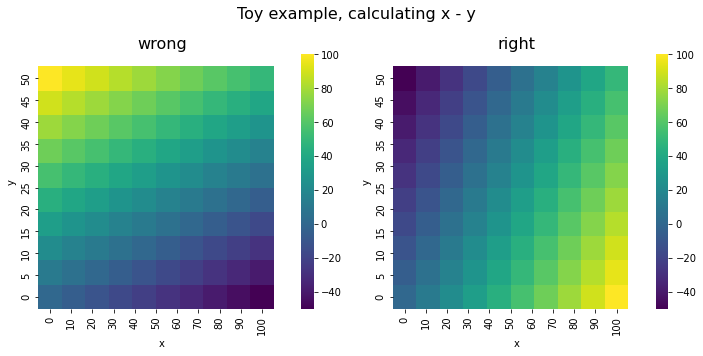

In [35]:
# Generate 2D heatmaps
fig, axes = plt.subplots(1,2, figsize=(10, 5))


x_range = np.linspace(0, 100, 10) 
y_range = np.linspace(0, 50, 10) 


x_ticks = np.linspace(x_range[0], x_range[-1], 11)
y_ticks = np.linspace(y_range[0], y_range[-1], 11)
xtick_pos = np.linspace(0.5, len(x_range) - 1 + 0.5, 11)
ytick_pos = np.linspace(0.5, len(y_range) - 1 + 0.5, 11)
grid_wrong = np.zeros((len(x_range), len(y_range)))
grid_right = np.zeros((len(x_range), len(y_range)))

for x_idx, x in enumerate(x_range):
    for y_idx, y in enumerate(y_range):
        grid_wrong[x_idx, y_idx] = x - y
        grid_right[y_idx, x_idx] = x - y # The right way to fill the grid is this one!

        
sns.heatmap(grid_wrong, ax=axes[0], xticklabels=x_ticks, yticklabels=y_ticks, cmap="viridis", cbar=True)
sns.heatmap(grid_right, ax=axes[1], xticklabels=x_ticks, yticklabels=y_ticks, cmap="viridis", cbar=True)

for ax_no in range(2):
    axes[ax_no].set_xticks(xtick_pos)
    axes[ax_no].set_xticklabels([f"{label:.0f}" for label in x_ticks])
    axes[ax_no].set_yticks(ytick_pos)
    axes[ax_no].set_yticklabels([f"{label:.0f}" for label in y_ticks])
    axes[ax_no].invert_yaxis()  # Fix y-axis direction, so we go from lowest to highest values
    axes[ax_no].set_xlabel("x")
    axes[ax_no].set_ylabel("y")

axes[0].set_title("wrong", fontsize=16)
axes[1].set_title("right", fontsize=16)
        
plt.suptitle("Toy example, calculating x - y", fontsize=16)
plt.tight_layout()
plt.show()


## Results with the muon Yukawa set to zero:

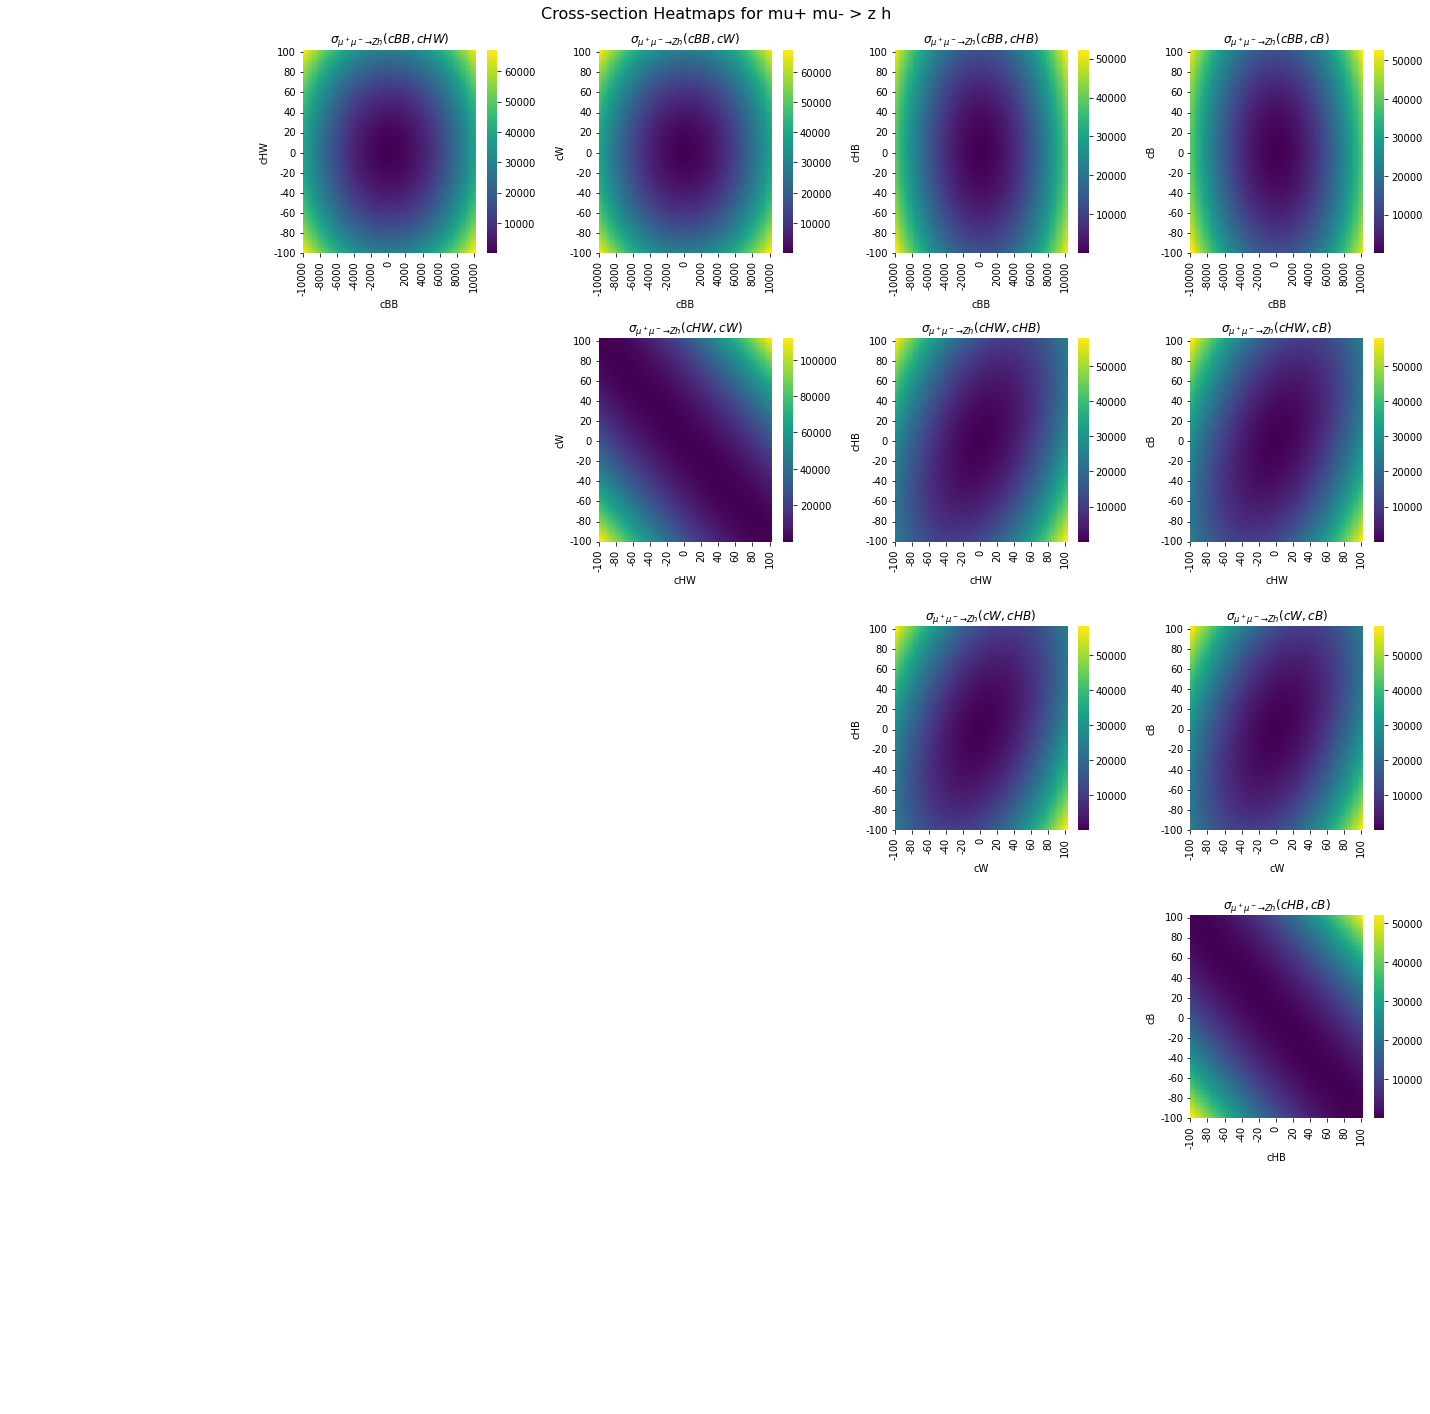

In [36]:
# Generate 2D heatmaps

def plot_heatmaps_grid(process_name):
    fig, axes = plt.subplots(len(params_list), len(params_list), figsize=(20, 20))
    

    
    for i in range(len(params_list)):
        for j in range(len(params_list)):
            if i >= j:
                axes[i, j].axis('off')
                continue
            
            p1, p2 = params_list[i], params_list[j]
            
            # Assign ranges based on whether p1 or p2 is cBB
            x_range = np.linspace(-10000, 10000, 75) if p1 == "cBB" else np.linspace(-100, 100, 75)
            y_range = np.linspace(-10000, 10000, 75) if p2 == "cBB" else np.linspace(-100, 100, 75)

            x_ticks = np.linspace(x_range[0], x_range[-1], 11)
            y_ticks = np.linspace(y_range[0], y_range[-1], 11)

            xtick_pos = np.linspace(0, len(x_range) - 1, 11)
            ytick_pos = np.linspace(0, len(y_range) - 1, 11)



            grid = np.zeros((len(x_range), len(y_range)))


            for x_idx, x in enumerate(x_range):
                for y_idx, y in enumerate(y_range):
                    coeffs = {p: 0 for p in params_list}
                    coeffs[p1] = x
                    coeffs[p2] = y
                    grid[y_idx, x_idx] = sigmaMupMumZh(coeffs)

            
            sns.heatmap(grid, ax=axes[i, j], xticklabels=x_ticks, yticklabels=y_ticks, cmap="viridis", cbar=True)
            axes[i, j].set_xticks(xtick_pos)
            axes[i, j].set_xticklabels([f"{label:.0f}" for label in x_ticks])
            axes[i, j].set_yticks(ytick_pos)
            axes[i, j].set_yticklabels([f"{label:.0f}" for label in y_ticks])
            axes[i, j].invert_yaxis()  # Fix y-axis direction
            axes[i, j].set_xlabel(p1)
            axes[i, j].set_ylabel(p2)
            axes[i, j].set_title(f"$\\sigma_{{\\mu^+ \\mu^- \\to Z h}}({p1}, {p2})$", fontsize=12)
            
    plt.suptitle(f"Cross-section Heatmaps for {process_name}\n", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_heatmaps_grid("mu+ mu- > z h")


Explicitly checking results:

In [37]:
coeffs1 = {
    "cBB": 0,
    "cHW": 0,
    "cW": 0,
    "cHB": 0,
    "cB": 0
}

coeffs2 = {
    "cBB": 0.0,
    "cHW": 0,
    "cW": 0,
    "cHB": 0,
    "cB": 5
}

print(sigmaMupMumZh(coeffs1), sigmaMupMumZh(coeffs2))

6.172022e-05 32.564819985220005


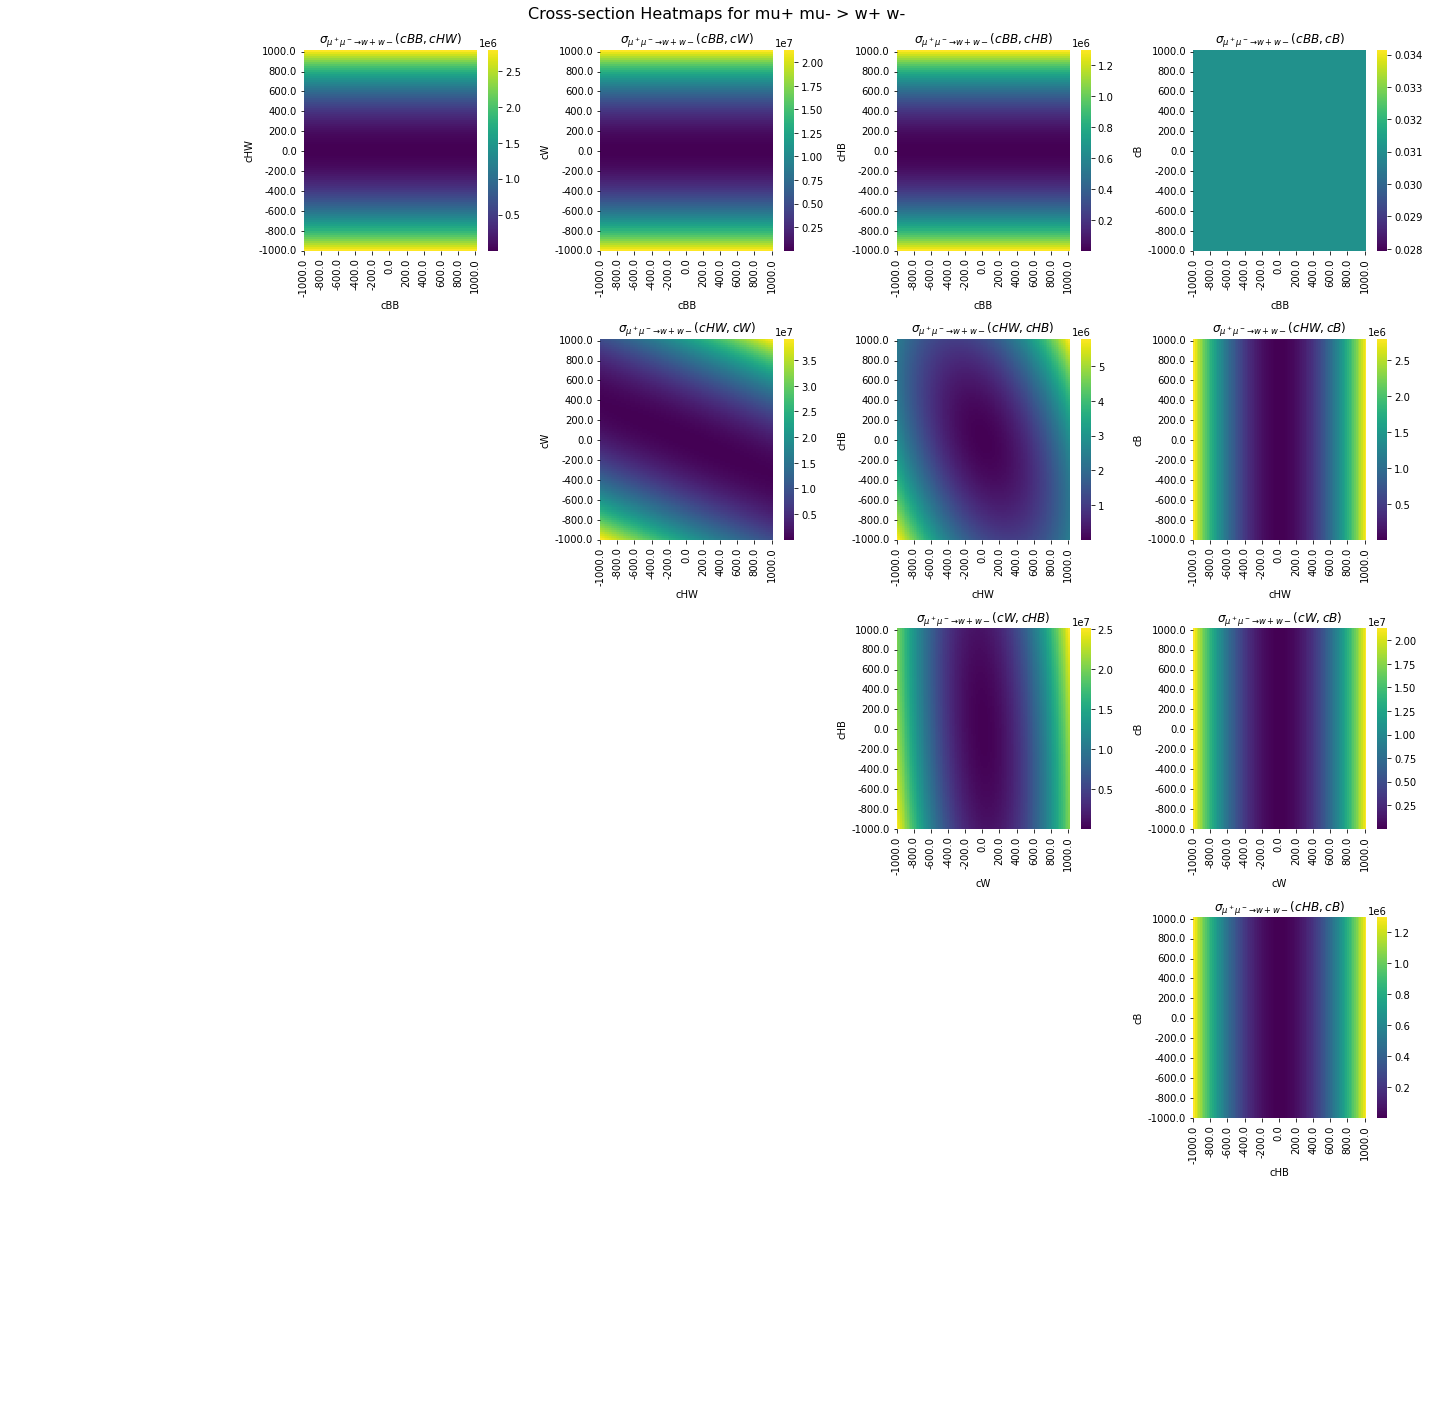

In [38]:
# Generate 2D heatmaps

def plot_heatmaps_grid(process_name):
    fig, axes = plt.subplots(len(params_list), len(params_list), figsize=(20, 20))
    

    
    for i in range(len(params_list)):
        for j in range(len(params_list)):
            if i >= j:
                axes[i, j].axis('off')
                continue
            
            p1, p2 = params_list[i], params_list[j]
            
            # Assign ranges based on whether p1 or p2 is cBB
            #x_range = np.linspace(-10000, 10000, 100) if p1 == "cBB" else np.linspace(-100, 100, 100)
            #y_range = np.linspace(-10000, 10000, 100) if p2 == "cBB" else np.linspace(-100, 100, 100)

            x_range = np.linspace(-1000, 1000, 100) 
            y_range = np.linspace(-1000, 1000, 100) 


            x_ticks = np.linspace(x_range[0], x_range[-1], 11)
            y_ticks = np.linspace(y_range[0], y_range[-1], 11)

            xtick_pos = np.linspace(0, len(x_range) - 1, 11)
            ytick_pos = np.linspace(0, len(y_range) - 1, 11)



            grid = np.zeros((len(x_range), len(y_range)))


            for x_idx, x in enumerate(x_range):
                for y_idx, y in enumerate(y_range):
                    coeffs = {p: 0 for p in params_list}
                    coeffs[p1] = x
                    coeffs[p2] = y
                    grid[y_idx, x_idx] = sigmaMupMumWW(coeffs)

            
            sns.heatmap(grid, ax=axes[i, j], xticklabels=x_ticks, yticklabels=y_ticks, cmap="viridis", cbar=True)
            axes[i, j].set_xticks(xtick_pos)
            axes[i, j].set_xticklabels([f"{label:.1f}" for label in x_ticks])
            axes[i, j].set_yticks(ytick_pos)
            axes[i, j].set_yticklabels([f"{label:.1f}" for label in y_ticks])
            axes[i, j].invert_yaxis()  # Fix y-axis direction
            axes[i, j].set_xlabel(p1)
            axes[i, j].set_ylabel(p2)
            axes[i, j].set_title(f"$\\sigma_{{\\mu^+ \\mu^- \\to w+ w-}}({p1}, {p2})$", fontsize=12)
            
    plt.suptitle(f"Cross-section Heatmaps for {process_name}\n", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_heatmaps_grid("mu+ mu- > w+ w-")


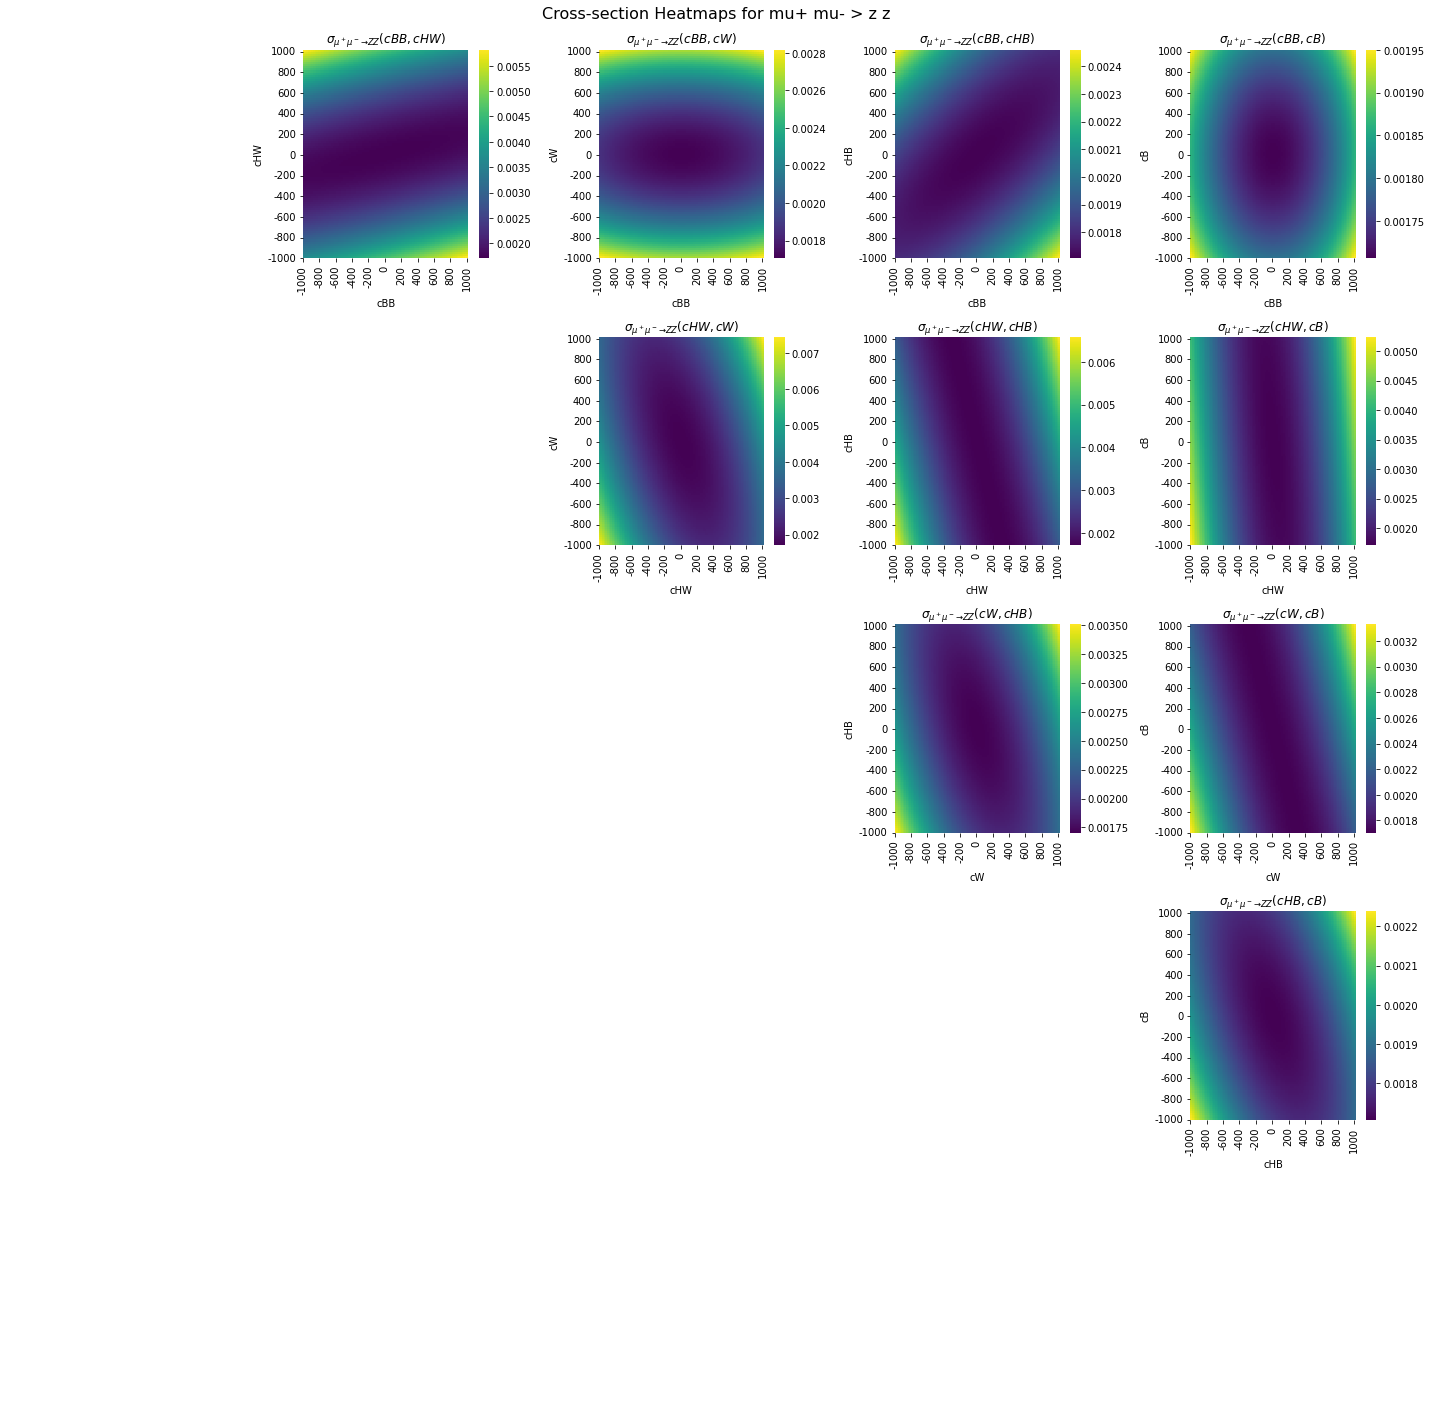

In [39]:
# Generate 2D heatmaps

def plot_heatmaps_grid(process_name):
    fig, axes = plt.subplots(len(params_list), len(params_list), figsize=(20, 20))
    

    
    for i in range(len(params_list)):
        for j in range(len(params_list)):
            if i >= j:
                axes[i, j].axis('off')
                continue
            
            p1, p2 = params_list[i], params_list[j]
            
            # Assign ranges 
            x_range = np.linspace(-1000, 1000, 100) 
            y_range = np.linspace(-1000, 1000, 100)

            x_ticks = np.linspace(x_range[0], x_range[-1], 11)
            y_ticks = np.linspace(y_range[0], y_range[-1], 11)

            xtick_pos = np.linspace(0, len(x_range) - 1, 11)
            ytick_pos = np.linspace(0, len(y_range) - 1, 11)



            grid = np.zeros((len(x_range), len(y_range)))


            for x_idx, x in enumerate(x_range):
                for y_idx, y in enumerate(y_range):
                    coeffs = {p: 0 for p in params_list}
                    coeffs[p1] = x
                    coeffs[p2] = y
                    grid[y_idx, x_idx] = sigmaMupMumZZ(coeffs)

            
            sns.heatmap(grid, ax=axes[i, j], xticklabels=x_ticks, yticklabels=y_ticks, cmap="viridis", cbar=True)
            axes[i, j].set_xticks(xtick_pos)
            axes[i, j].set_xticklabels([f"{label:.0f}" for label in x_ticks])
            axes[i, j].set_yticks(ytick_pos)
            axes[i, j].set_yticklabels([f"{label:.0f}" for label in y_ticks])
            axes[i, j].invert_yaxis()  # Fix y-axis direction
            axes[i, j].set_xlabel(p1)
            axes[i, j].set_ylabel(p2)
            axes[i, j].set_title(f"$\\sigma_{{\\mu^+ \\mu^- \\to Z Z}}({p1}, {p2})$", fontsize=12)
            
    plt.suptitle(f"Cross-section Heatmaps for {process_name}\n", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_heatmaps_grid("mu+ mu- > z z")


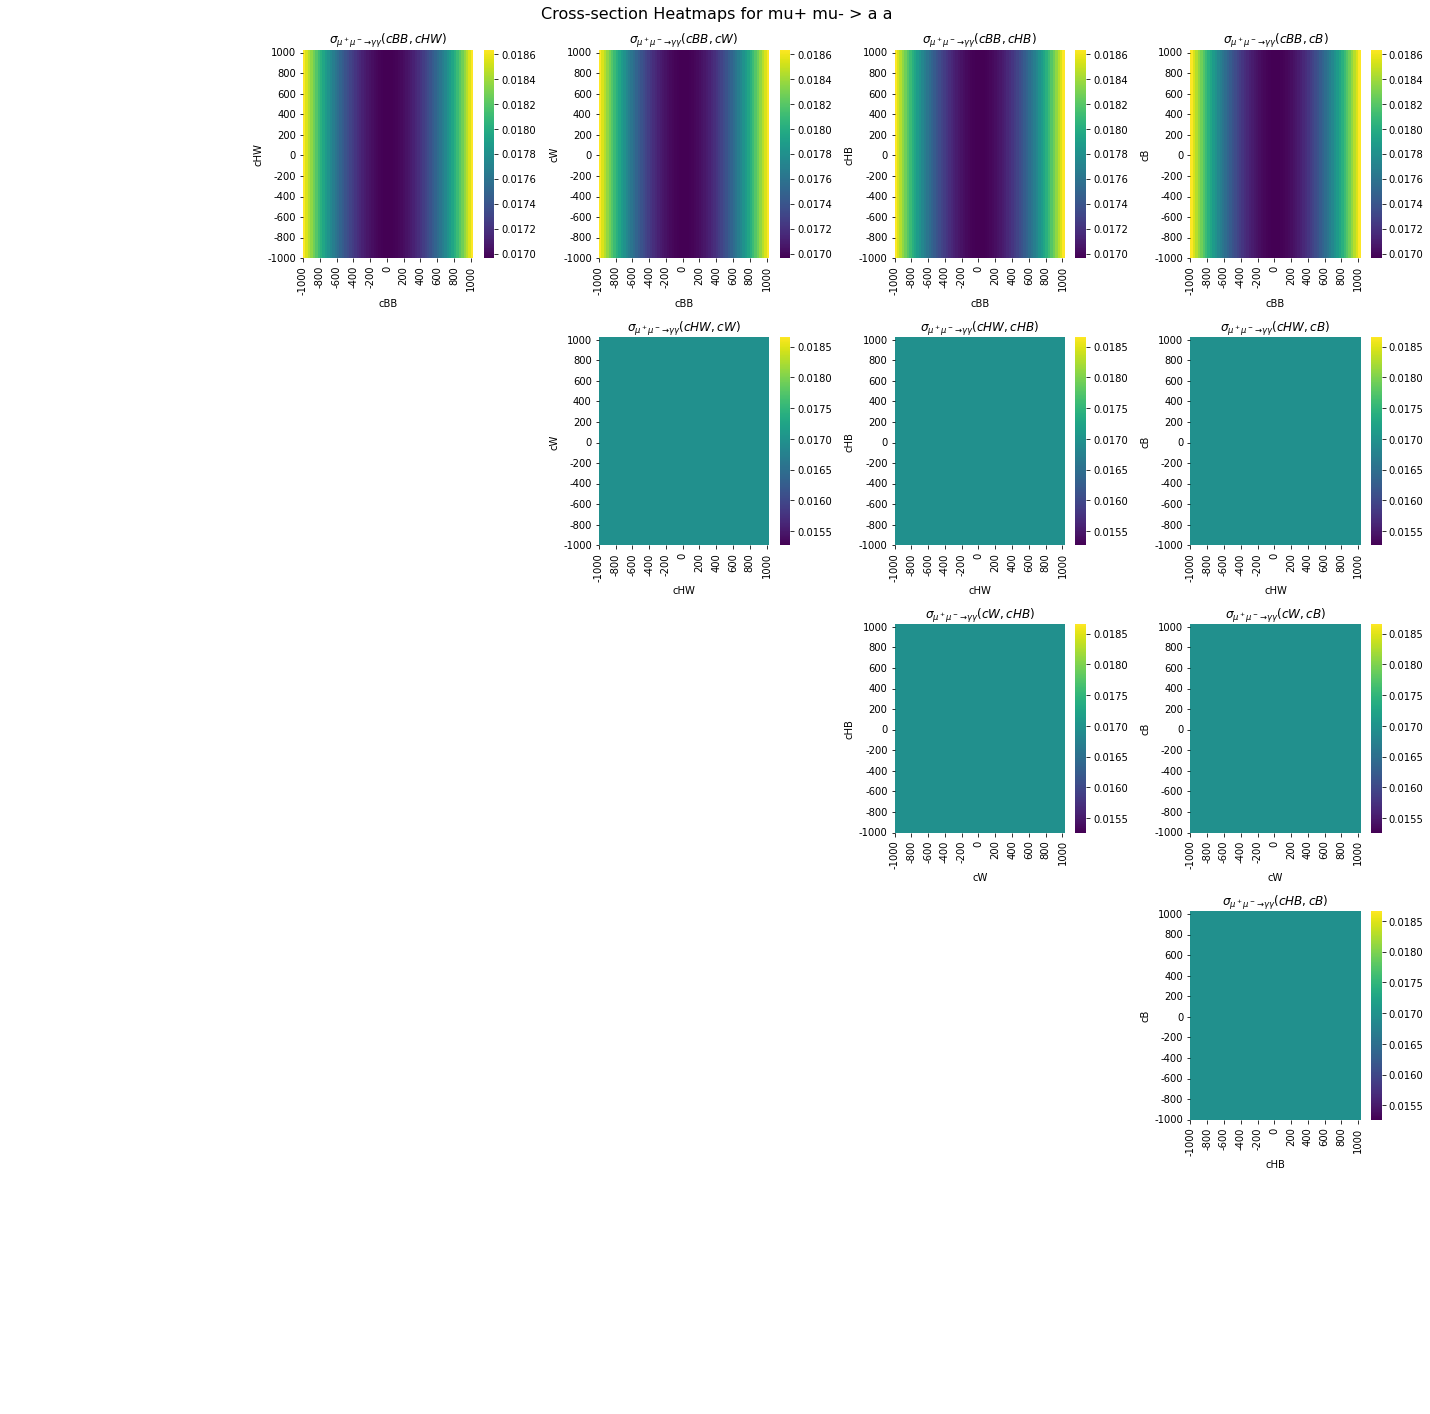

In [40]:
# Generate 2D heatmaps

def plot_heatmaps_grid(process_name):
    fig, axes = plt.subplots(len(params_list), len(params_list), figsize=(20, 20))
    

    
    for i in range(len(params_list)):
        for j in range(len(params_list)):
            if i >= j:
                axes[i, j].axis('off')
                continue
            
            p1, p2 = params_list[i], params_list[j]
            
            # Assign ranges 
            x_range = np.linspace(-1000, 1000, 70) 
            y_range = np.linspace(-1000, 1000, 70) 

            x_ticks = np.linspace(x_range[0], x_range[-1], 11)
            y_ticks = np.linspace(y_range[0], y_range[-1], 11)

            xtick_pos = np.linspace(0, len(x_range) - 1, 11)
            ytick_pos = np.linspace(0, len(y_range) - 1, 11)



            grid = np.zeros((len(x_range), len(y_range)))


            for x_idx, x in enumerate(x_range):
                for y_idx, y in enumerate(y_range):
                    coeffs = {p: 0 for p in params_list}
                    coeffs[p1] = x
                    coeffs[p2] = y
                    grid[y_idx, x_idx] = sigmaMupMumAA(coeffs)

            
            sns.heatmap(grid, ax=axes[i, j], xticklabels=x_ticks, yticklabels=y_ticks, cmap="viridis", cbar=True)
            axes[i, j].set_xticks(xtick_pos)
            axes[i, j].set_xticklabels([f"{label:.0f}" for label in x_ticks])
            axes[i, j].set_yticks(ytick_pos)
            axes[i, j].set_yticklabels([f"{label:.0f}" for label in y_ticks])
            axes[i, j].invert_yaxis()  # Fix y-axis direction
            axes[i, j].set_xlabel(p1)
            axes[i, j].set_ylabel(p2)
            axes[i, j].set_title(f"$\\sigma_{{\\mu^+ \\mu^- \\to \\gamma \\gamma}}({p1}, {p2})$", fontsize=12)
            
    plt.suptitle(f"Cross-section Heatmaps for {process_name}\n", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_heatmaps_grid("mu+ mu- > a a")


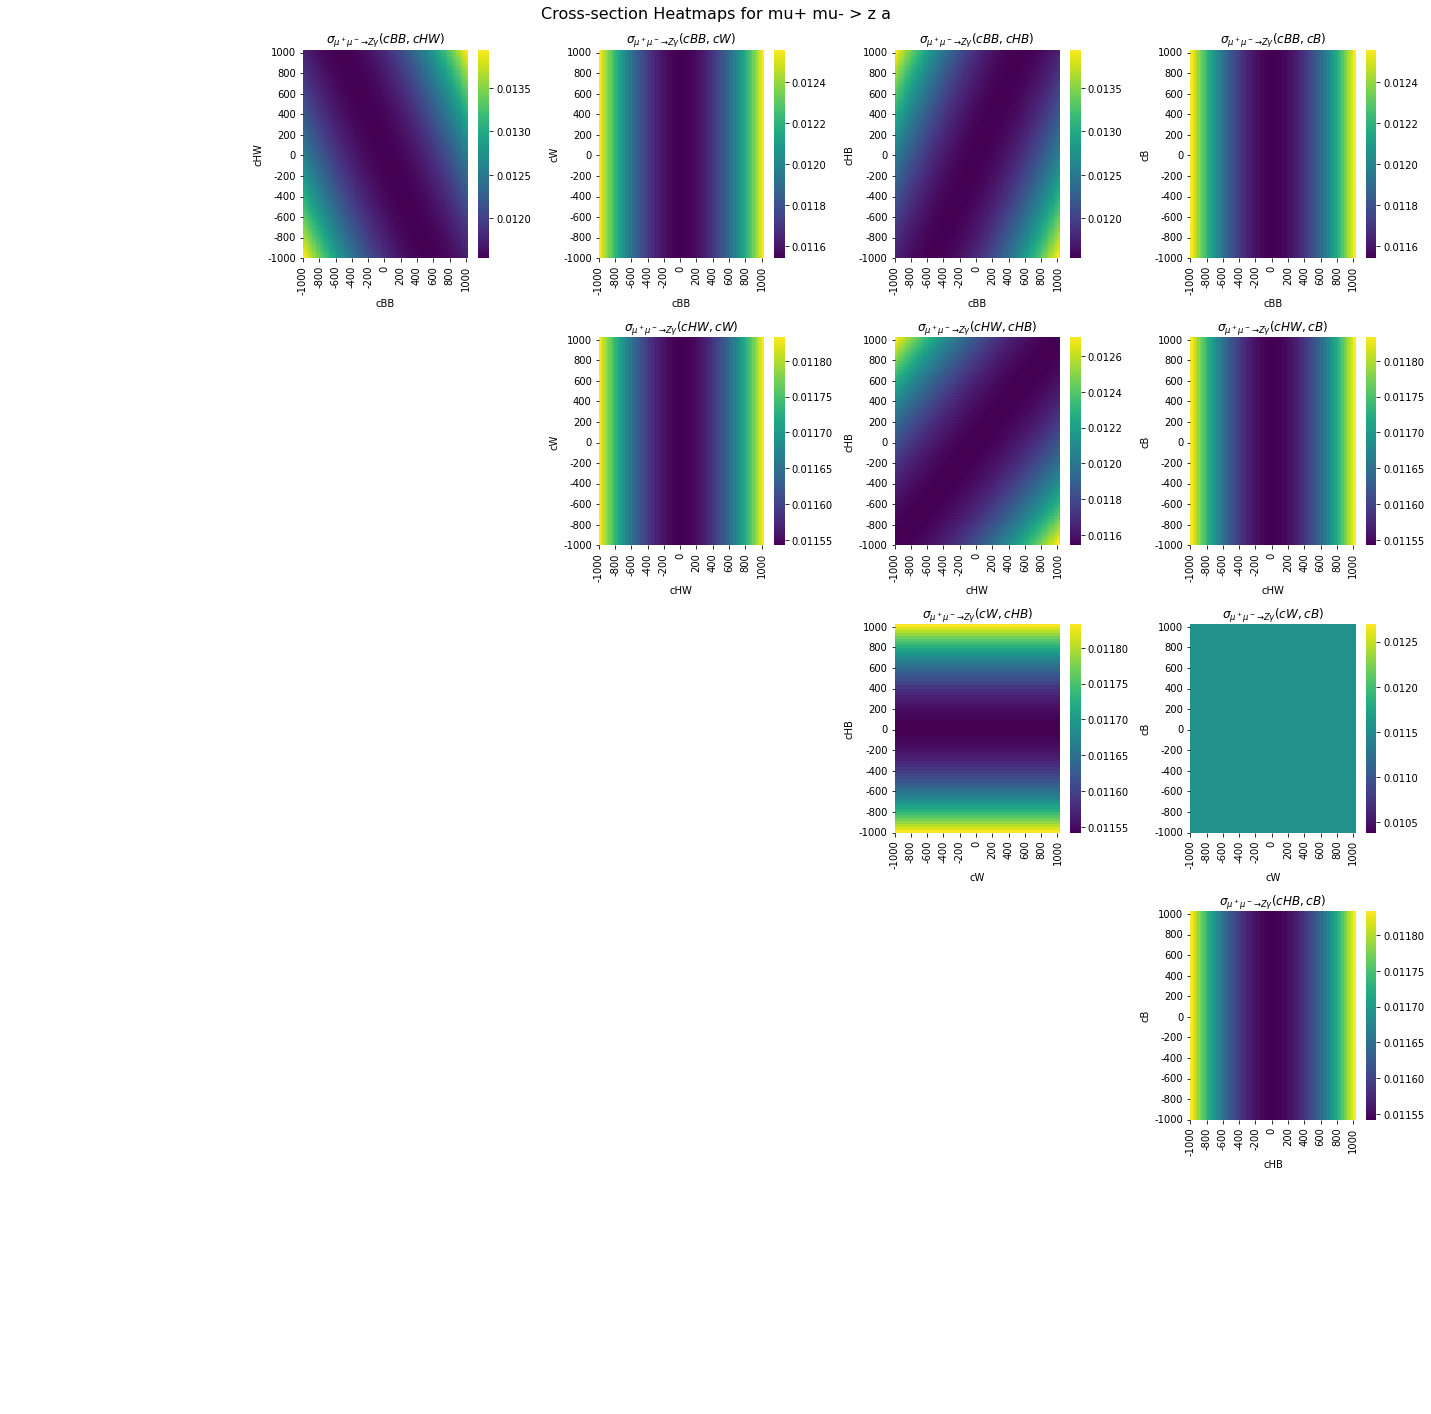

In [41]:
# Generate 2D heatmaps

def plot_heatmaps_grid(process_name):
    fig, axes = plt.subplots(len(params_list), len(params_list), figsize=(20, 20))
    

    
    for i in range(len(params_list)):
        for j in range(len(params_list)):
            if i >= j:
                axes[i, j].axis('off')
                continue
            
            p1, p2 = params_list[i], params_list[j]
            
            # Assign ranges 
            x_range = np.linspace(-1000, 1000, 70) 
            y_range = np.linspace(-1000, 1000, 70) 

            x_ticks = np.linspace(x_range[0], x_range[-1], 11)
            y_ticks = np.linspace(y_range[0], y_range[-1], 11)

            xtick_pos = np.linspace(0, len(x_range) - 1, 11)
            ytick_pos = np.linspace(0, len(y_range) - 1, 11)



            grid = np.zeros((len(x_range), len(y_range)))


            for x_idx, x in enumerate(x_range):
                for y_idx, y in enumerate(y_range):
                    coeffs = {p: 0 for p in params_list}
                    coeffs[p1] = x
                    coeffs[p2] = y
                    grid[y_idx, x_idx] = sigmaMupMumZa(coeffs)

            
            sns.heatmap(grid, ax=axes[i, j], xticklabels=x_ticks, yticklabels=y_ticks, cmap="viridis", cbar=True)
            axes[i, j].set_xticks(xtick_pos)
            axes[i, j].set_xticklabels([f"{label:.0f}" for label in x_ticks])
            axes[i, j].set_yticks(ytick_pos)
            axes[i, j].set_yticklabels([f"{label:.0f}" for label in y_ticks])
            axes[i, j].invert_yaxis()  # Fix y-axis direction
            axes[i, j].set_xlabel(p1)
            axes[i, j].set_ylabel(p2)
            axes[i, j].set_title(f"$\\sigma_{{\\mu^+ \\mu^- \\to Z \\gamma}}({p1}, {p2})$", fontsize=12)
            
    plt.suptitle(f"Cross-section Heatmaps for {process_name}\n", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_heatmaps_grid("mu+ mu- > z a")
